# Notebook to run basic `scanpy` QC and doublet detection with `scrublet` for Hubmap dataset - HBM385.LQVK.975

- **Developed by**: Srivalli Kolla

- **Created date** : 4 October, 2024

- **Modification date** : 23 October, 2024

- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**

Link for dataset :  https://portal.hubmapconsortium.org/browse/dataset/17f67cb15e59f65e640d85d2f3866cde

Env : Scanpy(Python 3.12.4)

# Import Packages

In [1]:
import anndata
import logging
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import os
import time
import matplotlib.pyplot as plt
from statsmodels.robust.scale import mad as median_abs_deviation
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
timestamp = time.strftime("%d_%m_%Y")

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
asttokens           NA
attr                23.2.0
cffi                1.16.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
defusedxml          0.7.1
distutils           3.12.4
django              5.0.6
executing           2.0.1
h5py                3.11.0
igraph              0.11.5
ipykernel           6.29.5
ipython_genutils    0.2.0
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
louvain             0.8.2
matplotlib          3.8.4
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.10.1
numpy               1.26.4
packaging           24.1
pandas              2.2.2
parso               0.8.4
patsy  

# Import Datasets

In [3]:
adata = sc.read_h5ad('../hubmap/data/HBM385_sc_rna_hubmap_sk.h5ad')
adata

AnnData object with n_obs × n_vars = 55605 × 60286
    obs: 'cell_id'
    var: 'hugo_symbol'
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced'

In [4]:
adata.obs['dataset'] = 'HBM385.LQVK.975'
adata.obs

,cell_id,dataset
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAACCATAGT,C03_C07_P2-C01_LIG97_W136.Apex,HBM385.LQVK.975
AACGCGCAGAAAGCCTACGAACGTCCGCAGAACGCGTCT,C03_C07_P2-C01_LIG104_W136.Apex,HBM385.LQVK.975
AACGCGCAGAAAGCCTACGAACGTCCGCAGAACGTAATCT,C03_C07_P2-C01_LIG105_W136.Apex,HBM385.LQVK.975
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAGCAGTATT,C03_C07_P2-C01_LIG108_W136.Apex,HBM385.LQVK.975
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAGTATTGGT,C03_C07_P2-C01_LIG111_W136.Apex,HBM385.LQVK.975
...,...,...
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATAAGCGAAT,B07_B05_P2-C02_LIG145_W136.Apex,HBM385.LQVK.975
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATTCAAGCAT,B07_B05_P2-C02_LIG160_W136.Apex,HBM385.LQVK.975
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATTCGCAATT,B07_B05_P2-C02_LIG161_W136.Apex,HBM385.LQVK.975
TGATTAGGTATTGAGAGAGTTTGCGAGGCACGAGGCAAT,B07_B05_P2-C02_LIG177_W136.Apex,HBM385.LQVK.975


In [5]:
adata.var

,hugo_symbol
ENSG00000000003.15,TSPAN6
ENSG00000000005.6,TNMD
ENSG00000000419.13,NaN
ENSG00000000457.14,SCYL3
ENSG00000000460.17,C1orf112
...,...
ENSG00000288640.1,NaN
ENSG00000288642.1,NaN
ENSG00000288643.1,NaN
ENSG00000288644.1,NaN


## Doublet score prediction

In [6]:
scrub = scr.Scrublet(adata.X)

doublet_scores, predicted_doublets = scrub.scrub_doublets()
            
adata.obs['doublet_scores'] = doublet_scores
adata.obs['predicted_doublets'] = predicted_doublets

Preprocessing...


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in divide
  w.setdiag(float(target_total) / tots_use)
/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.08
Detected doublet rate = 30.7%
Estimated detectable doublet fraction = 47.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 64.4%
Elapsed time: 78.1 seconds


In [7]:
adata.obs

,cell_id,dataset,doublet_scores,predicted_doublets
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAACCATAGT,C03_C07_P2-C01_LIG97_W136.Apex,HBM385.LQVK.975,0.135777,True
AACGCGCAGAAAGCCTACGAACGTCCGCAGAACGCGTCT,C03_C07_P2-C01_LIG104_W136.Apex,HBM385.LQVK.975,0.000156,False
AACGCGCAGAAAGCCTACGAACGTCCGCAGAACGTAATCT,C03_C07_P2-C01_LIG105_W136.Apex,HBM385.LQVK.975,0.059155,False
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAGCAGTATT,C03_C07_P2-C01_LIG108_W136.Apex,HBM385.LQVK.975,0.000156,False
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAGTATTGGT,C03_C07_P2-C01_LIG111_W136.Apex,HBM385.LQVK.975,0.000156,False
...,...,...,...,...
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATAAGCGAAT,B07_B05_P2-C02_LIG145_W136.Apex,HBM385.LQVK.975,0.000156,False
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATTCAAGCAT,B07_B05_P2-C02_LIG160_W136.Apex,HBM385.LQVK.975,0.211773,True
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATTCGCAATT,B07_B05_P2-C02_LIG161_W136.Apex,HBM385.LQVK.975,0.021531,False
TGATTAGGTATTGAGAGAGTTTGCGAGGCACGAGGCAAT,B07_B05_P2-C02_LIG177_W136.Apex,HBM385.LQVK.975,0.000156,False


### Checking the count and percentage of Doublets - Anndata level

In [8]:
doub_tab = pd.crosstab(adata.obs['dataset'],adata.obs['predicted_doublets'])
doub_tab.sum()

predicted_doublets
False    38542
True     17063
dtype: int64

In [9]:
true_doublets = adata.obs['predicted_doublets'] == True
true_doublets_count = true_doublets.sum()

true_doublets_percentage = (true_doublets_count / len(adata.obs)) * 100

true_doublets_count ,true_doublets_percentage

(17063, 30.6860893804514)

### Saving raw data

In [10]:
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 55605 × 60286
    obs: 'cell_id', 'dataset', 'doublet_scores', 'predicted_doublets'
    var: 'hugo_symbol'
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced'

## Compute QC stats

In [11]:
sample_object.shape

(55605, 60286)

### Labelling Mt and Ribo genes

In [12]:
sample_object.var['ensembl'] = sample_object.var.index 
sample_object.var.index = sample_object.var['hugo_symbol']

In [13]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var

,hugo_symbol,ensembl,mt,ribo
hugo_symbol,,,,
TSPAN6,TSPAN6,ENSG00000000003.15,False,False
TNMD,TNMD,ENSG00000000005.6,False,False
NaN,NaN,ENSG00000000419.13,NaN,NaN
SCYL3,SCYL3,ENSG00000000457.14,False,False
C1orf112,C1orf112,ENSG00000000460.17,False,False
...,...,...,...,...
NaN,NaN,ENSG00000288640.1,NaN,NaN
NaN,NaN,ENSG00000288642.1,NaN,NaN
NaN,NaN,ENSG00000288643.1,NaN,NaN


In [14]:
ribo_counts = sample_object.var['ribo'].value_counts()

mt_counts = sample_object.var['mt'].value_counts()

print("Counts of Ribosomal (ribo) Genes:")
print("False:", ribo_counts.get(False, 0))
print("True:", ribo_counts.get(True, 0))
print("\nCounts of Mitochondrial (mt) Genes:")
print("False:", mt_counts.get(False, 0))
print("True:", mt_counts.get(True, 0))

Counts of Ribosomal (ribo) Genes:
False: 55619
True: 1331

Counts of Mitochondrial (mt) Genes:
False: 56927
True: 23


In [15]:
sample_object.var['mt'] = sample_object.var['mt'].fillna(False)
sample_object.var['ribo'] = sample_object.var['ribo'].fillna(False)

/tmp/ipykernel_415271/674208150.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sample_object.var['mt'] = sample_object.var['mt'].fillna(False)
/tmp/ipykernel_415271/674208150.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sample_object.var['ribo'] = sample_object.var['ribo'].fillna(False)


### Calculating QC metrics per cell

In [16]:
sc.pp.calculate_qc_metrics(sample_object,qc_vars = ['mt','ribo'],inplace = True)

In [17]:
sample_object

AnnData object with n_obs × n_vars = 55605 × 60286
    obs: 'cell_id', 'dataset', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'hugo_symbol', 'ensembl', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced'

## Sex covariate analysis

### Ensembl annotations

In [18]:
sqlite_file = '../hubmap/.pybiomart.sqlite'

if os.path.exists(sqlite_file):
    os.remove(sqlite_file)
    print(f"Deleted cached BioMart annotations database at: {sqlite_file}")
else:
    print(f"No BioMart cache found at: {sqlite_file}")

Deleted cached BioMart annotations database at: ../hubmap/.pybiomart.sqlite


In [19]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("ensembl_gene_id")

In [20]:
annot.head()

,external_gene_name,start_position,end_position,chromosome_name
ensembl_gene_id,,,,
ENSG00000210049,MT-TF,577,647,MT
ENSG00000211459,MT-RNR1,648,1601,MT
ENSG00000210077,MT-TV,1602,1670,MT
ENSG00000210082,MT-RNR2,1671,3229,MT
ENSG00000209082,MT-TL1,3230,3304,MT


### Chr Y genes calculation

In [21]:
sample_object.var_names = sample_object.var['ensembl']
sample_object.var_names

Index(['ENSG00000000003.15', 'ENSG00000000005.6', 'ENSG00000000419.13',
       'ENSG00000000457.14', 'ENSG00000000460.17', 'ENSG00000000938.13',
       'ENSG00000000971.16', 'ENSG00000001036.14', 'ENSG00000001084.13',
       'ENSG00000001167.14',
       ...
       'ENSG00000288635.1', 'ENSG00000288636.1', 'ENSG00000288637.1',
       'ENSG00000288638.1', 'ENSG00000288639.1', 'ENSG00000288640.1',
       'ENSG00000288642.1', 'ENSG00000288643.1', 'ENSG00000288644.1',
       'ENSG00000288645.1'],
      dtype='object', name='ensembl', length=60286)

In [22]:
sample_object.var.index = sample_object.var.index.str.split('.').str[0]
sample_object.var

,hugo_symbol,ensembl,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ensembl,,,,,,,,,,
ENSG00000000003,TSPAN6,ENSG00000000003.15,False,False,30,0.000477,0.000476,99.946048,26.500000,3.314186
ENSG00000000005,TNMD,ENSG00000000005.6,False,False,0,0.000000,0.000000,100.000000,0.000000,0.000000
ENSG00000000419,NaN,ENSG00000000419.13,False,False,56,0.000569,0.000569,99.899290,31.666664,3.486355
ENSG00000000457,SCYL3,ENSG00000000457.14,False,False,32,0.000305,0.000304,99.942451,16.933334,2.886661
ENSG00000000460,C1orf112,ENSG00000000460.17,False,False,15,0.000132,0.000132,99.973024,7.333333,2.120264
...,...,...,...,...,...,...,...,...,...,...
ENSG00000288640,NaN,ENSG00000288640.1,False,False,12,0.000103,0.000103,99.978419,5.750000,1.909543
ENSG00000288642,NaN,ENSG00000288642.1,False,False,10,0.000060,0.000060,99.982016,3.333330,1.466336
ENSG00000288643,NaN,ENSG00000288643.1,False,False,1,0.000004,0.000004,99.998202,0.250000,0.223144


In [23]:
sample_object.var['corrected_ensembl'] = sample_object.var.index
sample_object.var

,hugo_symbol,ensembl,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,corrected_ensembl
ensembl,,,,,,,,,,,
ENSG00000000003,TSPAN6,ENSG00000000003.15,False,False,30,0.000477,0.000476,99.946048,26.500000,3.314186,ENSG00000000003
ENSG00000000005,TNMD,ENSG00000000005.6,False,False,0,0.000000,0.000000,100.000000,0.000000,0.000000,ENSG00000000005
ENSG00000000419,NaN,ENSG00000000419.13,False,False,56,0.000569,0.000569,99.899290,31.666664,3.486355,ENSG00000000419
ENSG00000000457,SCYL3,ENSG00000000457.14,False,False,32,0.000305,0.000304,99.942451,16.933334,2.886661,ENSG00000000457
ENSG00000000460,C1orf112,ENSG00000000460.17,False,False,15,0.000132,0.000132,99.973024,7.333333,2.120264,ENSG00000000460
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288640,NaN,ENSG00000288640.1,False,False,12,0.000103,0.000103,99.978419,5.750000,1.909543,ENSG00000288640
ENSG00000288642,NaN,ENSG00000288642.1,False,False,10,0.000060,0.000060,99.982016,3.333330,1.466336,ENSG00000288642
ENSG00000288643,NaN,ENSG00000288643.1,False,False,1,0.000004,0.000004,99.998202,0.250000,0.223144,ENSG00000288643


In [24]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['ENSG00000012817', 'ENSG00000067048', 'ENSG00000067646',
       'ENSG00000092377', 'ENSG00000099715', 'ENSG00000099721',
       'ENSG00000099725', 'ENSG00000114374', 'ENSG00000129816',
       'ENSG00000129824',
       ...
       'ENSG00000286120', 'ENSG00000286130', 'ENSG00000286173',
       'ENSG00000286187', 'ENSG00000286201', 'ENSG00000286217',
       'ENSG00000286247', 'ENSG00000286744', 'ENSG00000288049',
       'ENSG00000288057'],
      dtype='object', length=488)

In [25]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1) * 100

/tmp/ipykernel_415271/1554486360.py:1: RuntimeWarning: invalid value encountered in divide
  sample_object.obs['percent_chrY'] = np.sum(


In [26]:
sample_object

AnnData object with n_obs × n_vars = 55605 × 60286
    obs: 'cell_id', 'dataset', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'percent_chrY'
    var: 'hugo_symbol', 'ensembl', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'corrected_ensembl'
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced'

### XIST counts

In [27]:
sample_object.var_names = sample_object.var['hugo_symbol']
sample_object.var_names

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', nan, 'SCYL3', 'C1orf112']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


CategoricalIndex(['TSPAN6', 'TNMD', nan, 'SCYL3', 'C1orf112', 'FGR', nan,
                  'FUCA2', 'GCLC', 'NFYA',
                  ...
                  nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
                 categories=['5S_rRNA', '5_8S_rRNA', '7SK', 'A1BG', ..., 'ZZZ3', 'hsa-mir-423', 'hsa-mir-1253', 'snoZ196'], ordered=False, dtype='category', name='hugo_symbol', length=60286)

In [28]:
valid_var_names = sample_object.var_names[~sample_object.var_names.isna()]

xist_genes = valid_var_names[valid_var_names.str.match('XIST')]
if xist_genes.empty:
    raise ValueError("XIST gene not found in the variable names.")

xist_counts = sample_object.X[:, sample_object.var_names.isin(xist_genes)].toarray()

total_counts = sample_object.obs['total_counts'].fillna(0)

xist_percentage = np.where(total_counts > 0, (np.sum(xist_counts, axis=1) / total_counts) * 100, 0)

xist_counts_series = pd.Series(xist_counts.squeeze(), index=sample_object.obs_names, name="XIST-counts").fillna(0)
xist_percentage_series = pd.Series(xist_percentage, index=sample_object.obs_names, name="percent_XIST").fillna(0)

sample_object.obs["XIST-counts"] = xist_counts_series.astype(float)  
sample_object.obs["XIST-percentage"] = xist_percentage_series.astype(float) 

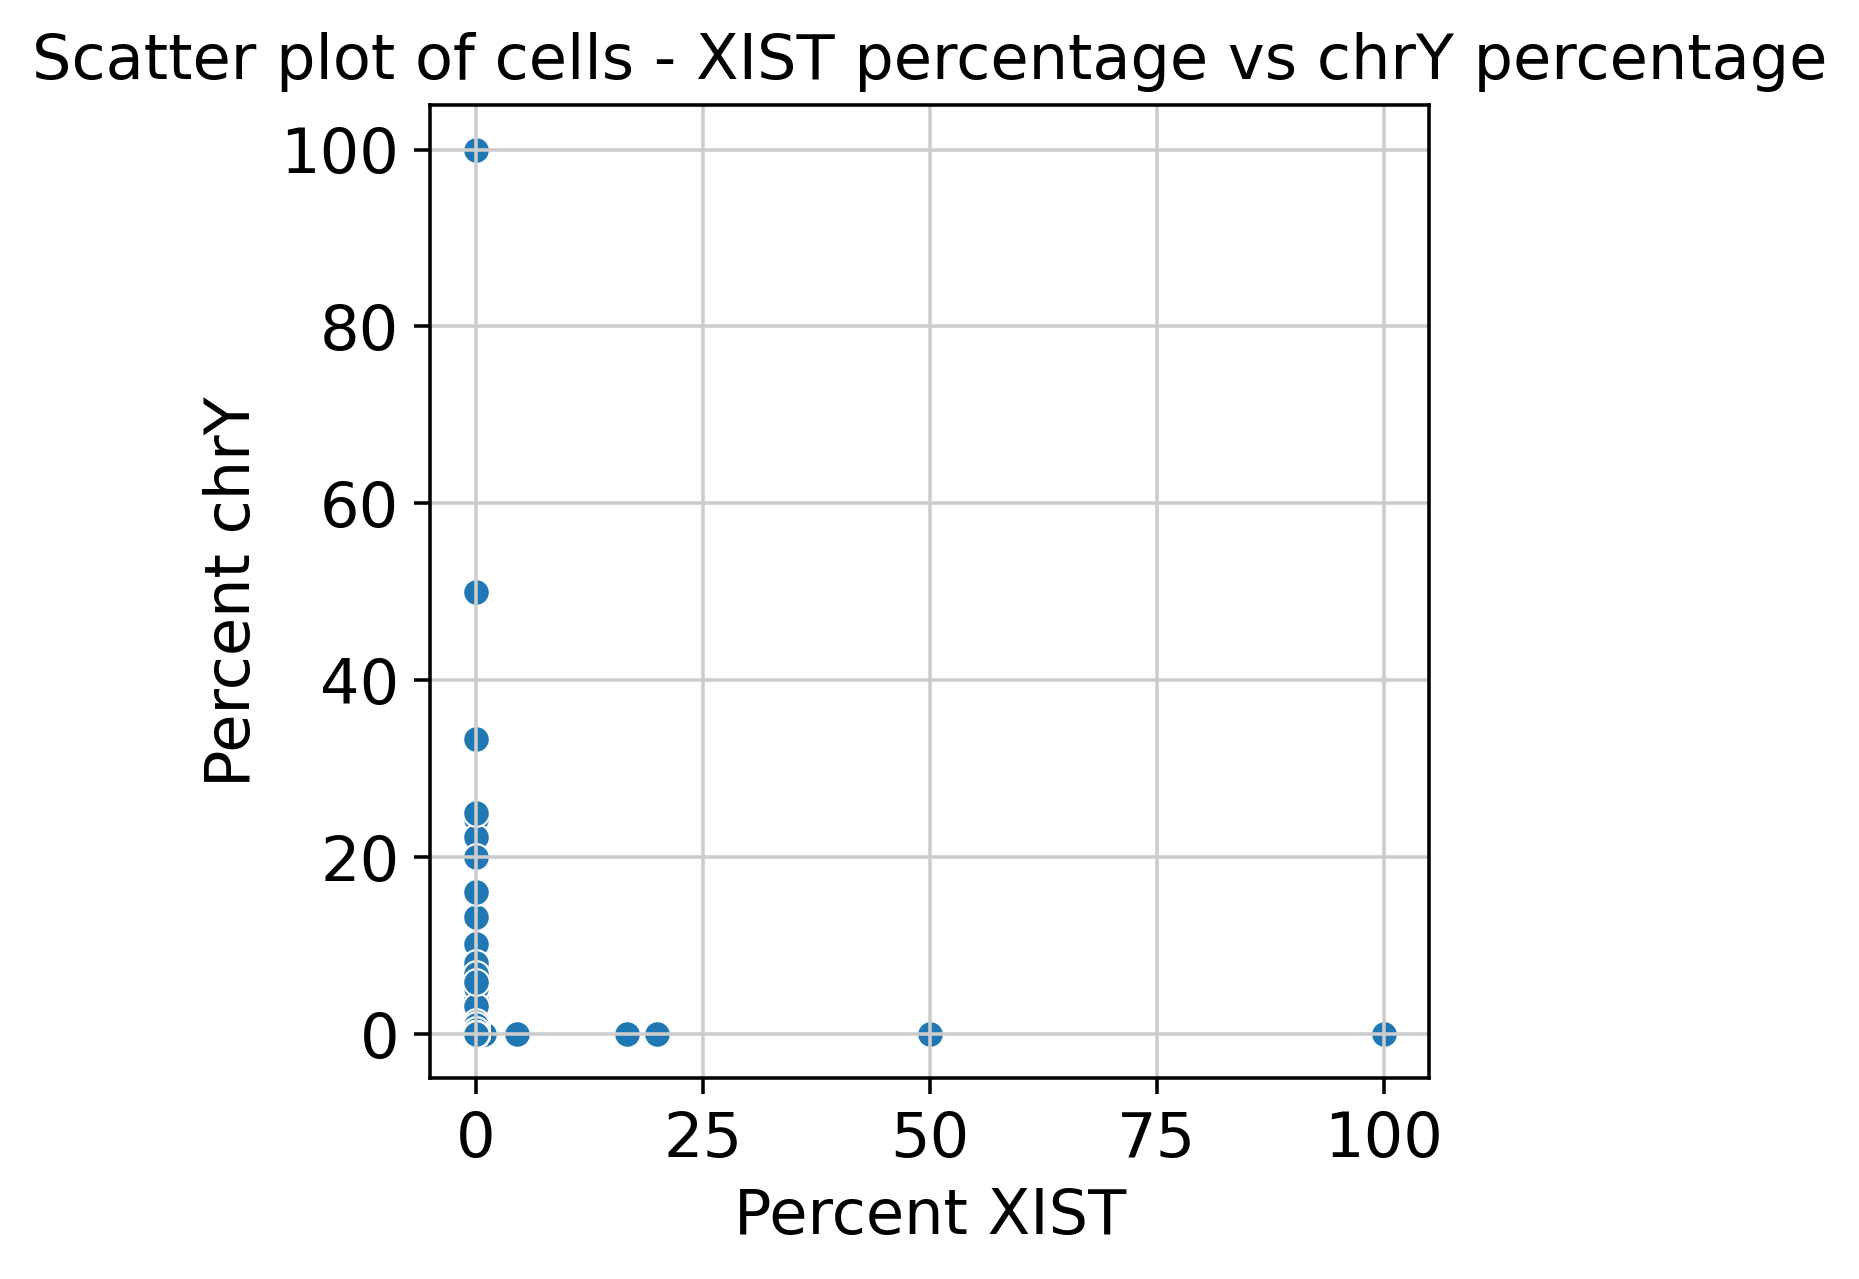

In [29]:
sb.scatterplot(data=sample_object.obs, x="XIST-percentage", y='percent_chrY')
plt.xlabel('Percent XIST')
plt.ylabel('Percent chrY')
plt.title('Scatter plot of cells - XIST percentage vs chrY percentage')
plt.show()

### Validation of sex covariates

In [30]:
zero_y_counts = len(sample_object.obs[sample_object.obs['percent_chrY'] == 0])
zero_xist_counts = len(sample_object.obs[sample_object.obs['XIST-percentage'] == 0])
both_zero_counts = len(sample_object.obs[(sample_object.obs['percent_chrY'] == 0) & (sample_object.obs['XIST-percentage'] == 0)])

print("Number of observations with 0 Y chromosome counts:", zero_y_counts)
print("Number of observations with 0 XIST counts:", zero_xist_counts)
print("Number of observations with both 0 Y chromosome counts and 0 XIST counts:", both_zero_counts)

Number of observations with 0 Y chromosome counts: 36221
Number of observations with 0 XIST counts: 55591
Number of observations with both 0 Y chromosome counts and 0 XIST counts: 36207


#### Steps followed - Cellular level

1. Create a 'gender_check_cov' variable and classify as male and female based on chrY percentage and XIST percentage
2. Create a 'gender_comparison' variable and classify as true or false in comparision with gender col we have
3. Calculate the counts of True and false
4. Calculate the percentage of True and false counts

In [31]:
sample_object.obs['gender_check_cov'] = np.where(
    (sample_object.obs['percent_chrY'] == 0) & (sample_object.obs['XIST-percentage'] == 0),
    'None',
    np.where(
        sample_object.obs['percent_chrY'] > sample_object.obs['XIST-percentage'],
        'Male',
        'Female'
    )
)

sample_object.obs

,cell_id,dataset,doublet_scores,predicted_doublets,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,...,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,percent_chrY,XIST-counts,XIST-percentage,gender_check_cov
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAACCATAGT,C03_C07_P2-C01_LIG97_W136.Apex,HBM385.LQVK.975,0.135777,True,29,3.401197,20.738094,3.079066,100.000009,100.000009,...,0.0,0.000000,0.000000,3.285714,1.455287,15.843857,0.0,0.0,0.0,None
AACGCGCAGAAAGCCTACGAACGTCCGCAGAACGCGTCT,C03_C07_P2-C01_LIG104_W136.Apex,HBM385.LQVK.975,0.000156,False,3,1.386294,1.666666,0.980829,100.000000,100.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,None
AACGCGCAGAAAGCCTACGAACGTCCGCAGAACGTAATCT,C03_C07_P2-C01_LIG105_W136.Apex,HBM385.LQVK.975,0.059155,False,93,4.543295,73.875000,4.315820,75.126904,99.999990,...,0.0,0.000000,0.000000,2.333333,1.203973,3.158488,0.0,0.0,0.0,None
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAGCAGTATT,C03_C07_P2-C01_LIG108_W136.Apex,HBM385.LQVK.975,0.000156,False,0,0.000000,0.000000,0.000000,NaN,NaN,...,0.0,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.0,0.0,Female
AACGCGCAGAAAGCCTACGAACGTCCGCAGAAGTATTGGT,C03_C07_P2-C01_LIG111_W136.Apex,HBM385.LQVK.975,0.000156,False,0,0.000000,0.000000,0.000000,NaN,NaN,...,0.0,0.000000,NaN,0.000000,0.000000,NaN,NaN,0.0,0.0,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATAAGCGAAT,B07_B05_P2-C02_LIG145_W136.Apex,HBM385.LQVK.975,0.000156,False,1,0.693147,1.000000,0.693147,100.000000,100.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,None
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATTCAAGCAT,B07_B05_P2-C02_LIG160_W136.Apex,HBM385.LQVK.975,0.211773,True,155,5.049856,187.013214,5.236512,62.829795,87.159631,...,0.0,0.000000,0.000000,0.500000,0.405465,0.267361,0.0,0.0,0.0,None
TGATTAGGTATTGAGAGAGTTTGCGAGGCAATTCGCAATT,B07_B05_P2-C02_LIG161_W136.Apex,HBM385.LQVK.975,0.021531,False,140,4.948760,110.083328,4.710280,54.958364,87.206660,...,1.0,0.693147,0.908403,2.400000,1.223776,2.180167,0.0,0.0,0.0,None
TGATTAGGTATTGAGAGAGTTTGCGAGGCACGAGGCAAT,B07_B05_P2-C02_LIG177_W136.Apex,HBM385.LQVK.975,0.000156,False,1,0.693147,1.000000,0.693147,100.000000,100.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,None


In [32]:
gender_counts = sample_object.obs['gender_check_cov'].value_counts()

if 'Male' in gender_counts.index and 'Female' in gender_counts.index and 'None' in gender_counts.index:
    if gender_counts['None'] > gender_counts['Male'] and gender_counts['None'] > gender_counts['Female']:
        sample_gender = 'None'
    elif gender_counts['Male'] > gender_counts['Female']:
        sample_gender = 'Male'
    else:
        sample_gender = 'Female'
elif 'Male' in gender_counts.index and 'Female' in gender_counts.index:
    if gender_counts['Male'] > gender_counts['Female']:
        sample_gender = 'Male'
    else:
        sample_gender = 'Female'
elif 'Male' in gender_counts.index:
    sample_gender = 'Male'
elif 'Female' in gender_counts.index:
    sample_gender = 'Female'
else:
    sample_gender = 'None'

sample_gender

'None'

## Calculate cell cycle scores

### Downloading the list of cell cycle genes

In [33]:
!if [ ! -f ../hubmap/data/regev_lab_cell_cycle_genes.txt ]; then curl -o ../hubmap/data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

### Marking cell cycle genes

#### Steps followed

1. Loading genes and captilizing 
2. Printing the length of cell cycle genes list
3. Split genes into 2 lists (#First 43 genes,#Gene 43 to end)
4. Filtering cell cycle genes only if present in processed_gene_names
5. Print the list of cell cycle genes observed in our data

In [34]:
cell_cycle_genes = [x.strip() for x in open('../hubmap/data/regev_lab_cell_cycle_genes.txt')]
#cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes]
print(len(cell_cycle_genes))

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
84


In [35]:
cell_cycle_genes

['MCM5',
 'PCNA',
 'TYMS',
 'FEN1',
 'MCM2',
 'MCM4',
 'RRM1',
 'GINS2',
 'MCM6',
 'CDCA7',
 'DTL',
 'PRIM1',
 'UHRF1',
 'HELLS',
 'RFC2',
 'RPA2',
 'NASP',
 'RAD51AP1',
 'GMNN',
 'WDR76',
 'SLBP',
 'CCNE2',
 'UBR7',
 'POLD3',
 'ATAD2',
 'RAD51',
 'RRM2',
 'CDC6',
 'EXO1',
 'TIPIN',
 'DSCC1',
 'BLM',
 'USP1',
 'CLSPN',
 'CHAF1B',
 'E2F8',
 'HMGB2',
 'CDK1',
 'NUSAP1',
 'UBE2C',
 'BIRC5',
 'TPX2',
 'TOP2A',
 'NDC80',
 'CKS2',
 'NUF2',
 'CKS1B',
 'MKI67',
 'CENPF',
 'SMC4',
 'CCNB2',
 'CKAP2L',
 'CKAP2',
 'AURKB',
 'BUB1',
 'KIF11',
 'ANP32E',
 'TUBB4B',
 'GTSE1',
 'KIF20B',
 'HJURP',
 'CDCA3',
 'CDC20',
 'TTK',
 'CDC25C',
 'KIF2C',
 'NCAPD2',
 'DLGAP5',
 'CDCA2',
 'CDCA8',
 'ECT2',
 'KIF23',
 'HMMR',
 'AURKA',
 'PSRC1',
 'ANLN',
 'LBR',
 'CKAP5',
 'CTCF',
 'NEK2',
 'G2E3',
 'GAS2L3',
 'CBX5',
 'CENPA']

### Creating basic anndata and normalization for cell cycle score calculation

In [36]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
[nan, nan, 'FUCA2', 'GCLC', 'NIPAL3', 'ENPP4', 'SEMA3F', 'ANKIB1', 'CYP51A1', nan, 'RAD52', nan, 'LAP3', nan, 'HS3ST1', 'MAD1L1', 'LASP1', nan, 'TMEM176A', 'M6PR', 'ICA1', nan, 'CFLAR', 'TFPI', 'NDUFAF7', 'RBM5', 'ARF5', 'POLDIP2', nan, 'AK2', 'CD38', 'FKBP4', 'RBM6', 'RECQL', 'HSPB6', 'NDUFAB1', 'PDK4', 'CDC27', 'HCCS', 'DVL2', nan, 'SKAP2', 'SLC25A5', 'MCUB', 'POLR2J', 'DHX33', nan, 'THSD7A', 'LIG3', 'RPAP3', 'ACSM3', 'CIAPIN1', 'SPPL2B', nan, 'COPZ2', 'PRKAR2B', 'MSL3', nan, 'TSPOAP1', 'GCFC2', nan, 'KMT2E', 'RHBDD2', 'IBTK', 'ZNF195', 'MYCBP2', 'FBXL3', 'ITGAL', 'PDK2', 'ITGA3', 'ZFX', nan, 'GDE1', 'CRLF1', 'TMEM98', nan, 'AP2B1', 'CX3CL1', 'SPATA20', 'RALA', 'KDM7A', 'ETV1', 'AGK', 'PHTF2', 'FARP2', 'GGCT', 'DBF4', nan, 'GTF2IRD1', 'VPS41', 'ELAC2', 'SCIN', 'ARSD', 'ADIPOR2', 'MARK4', 'CCDC124', nan, 'KIAA0100', 'GAS7', 'TRAPPC6A', nan, 'ST7L', 'RPUSD1', 'R

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


### Cell cycle score calculation

In [37]:
adata_log.var_names = adata_log.var_names.astype(str)
adata_log.var_names_make_unique()

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [38]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)

sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object.obs['phase'] = adata_log.obs['phase']

sample_object

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    386 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    429 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


AnnData object with n_obs × n_vars = 55605 × 60286
    obs: 'cell_id', 'dataset', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'hugo_symbol', 'ensembl', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'corrected_ensembl'
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced'

In [39]:
cell_cycle_counts = sample_object.obs['phase'].value_counts()

cell_cycle_counts

phase
S      49971
G1      3611
G2M     2023
Name: count, dtype: int64

<Axes: xlabel='phase', ylabel='count'>

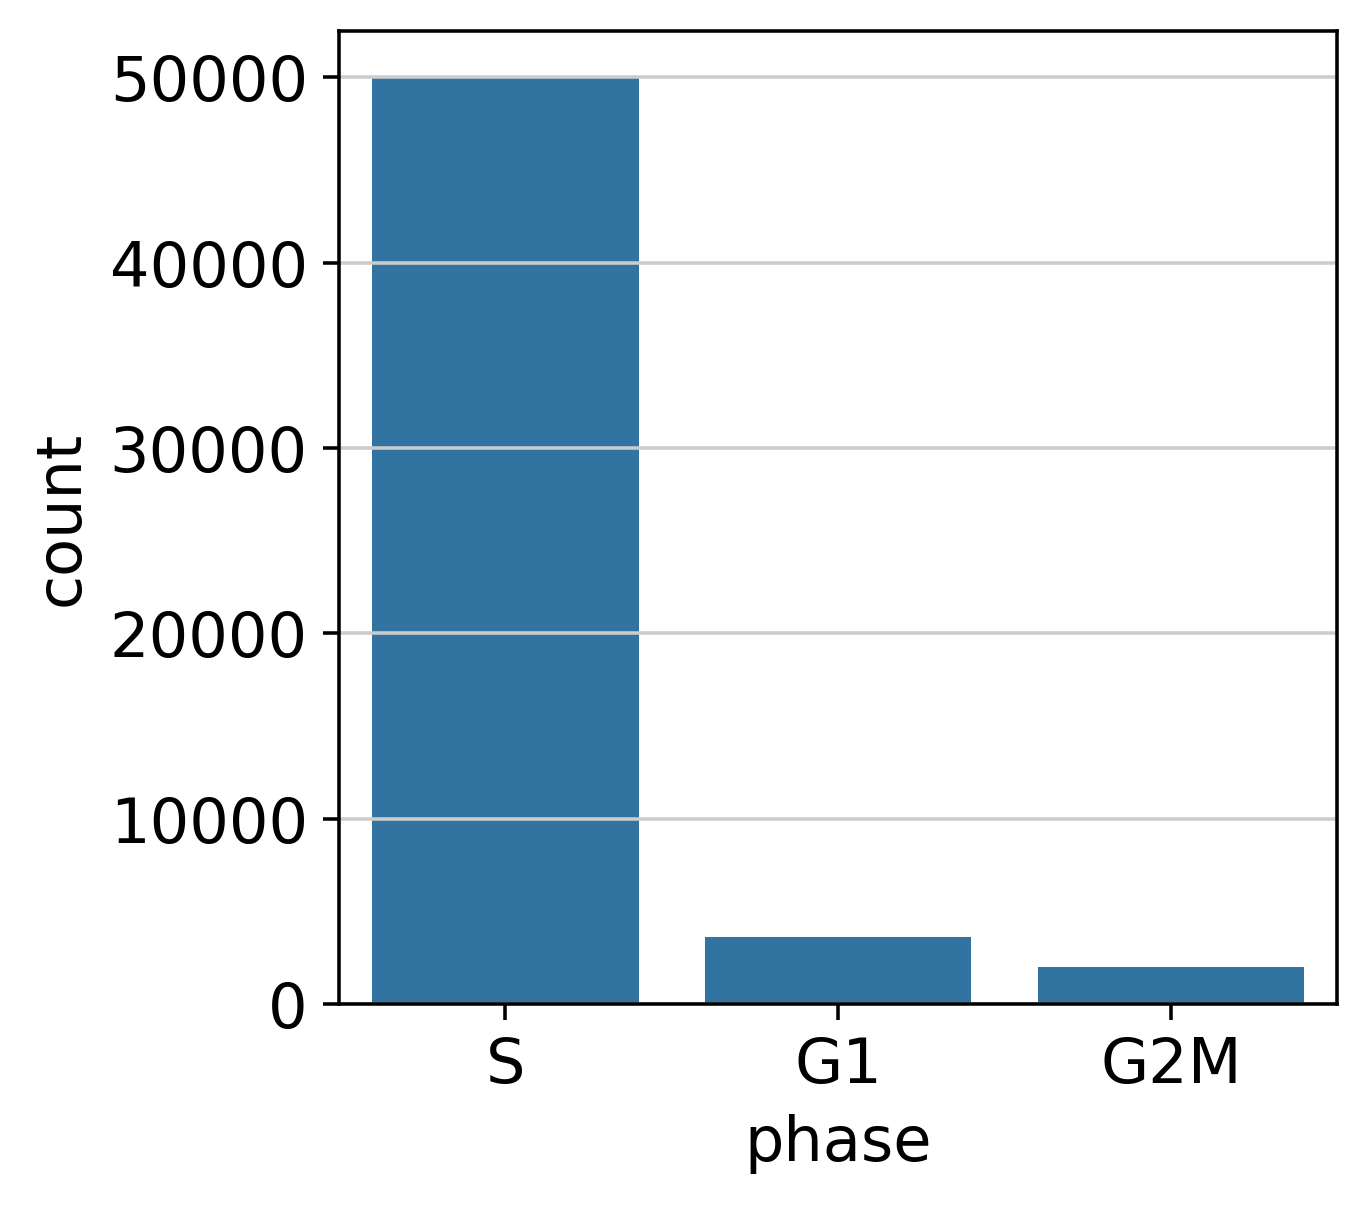

In [40]:
sb.countplot(data=sample_object.obs, x='phase')

## Data visualization

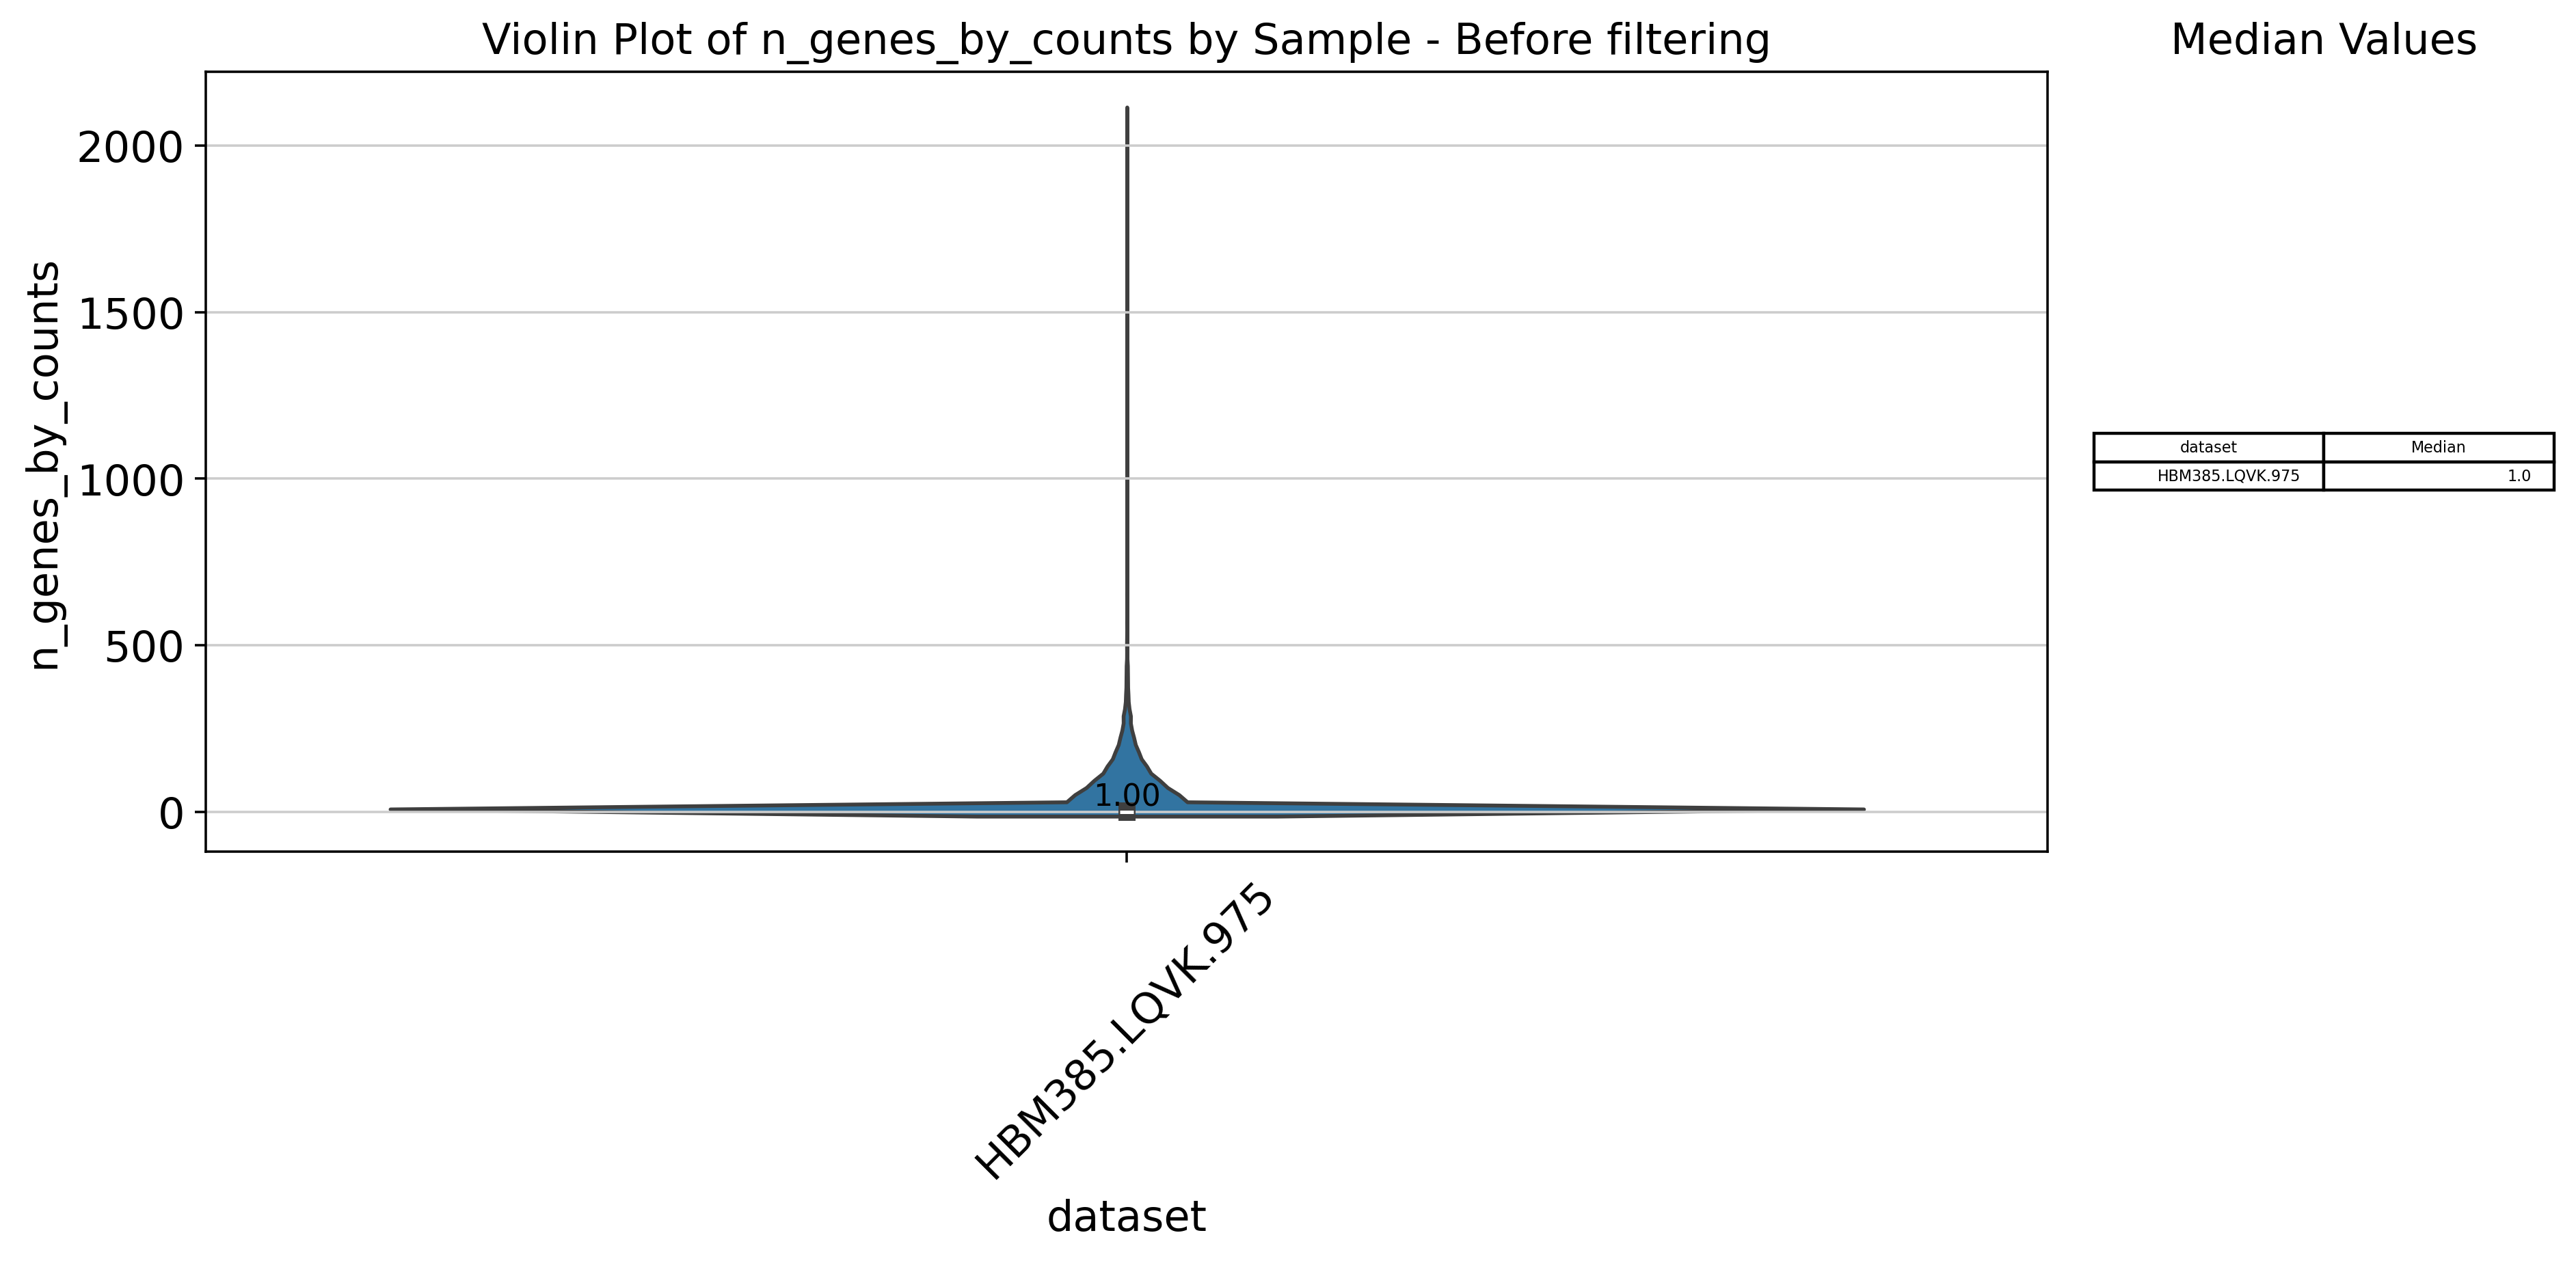

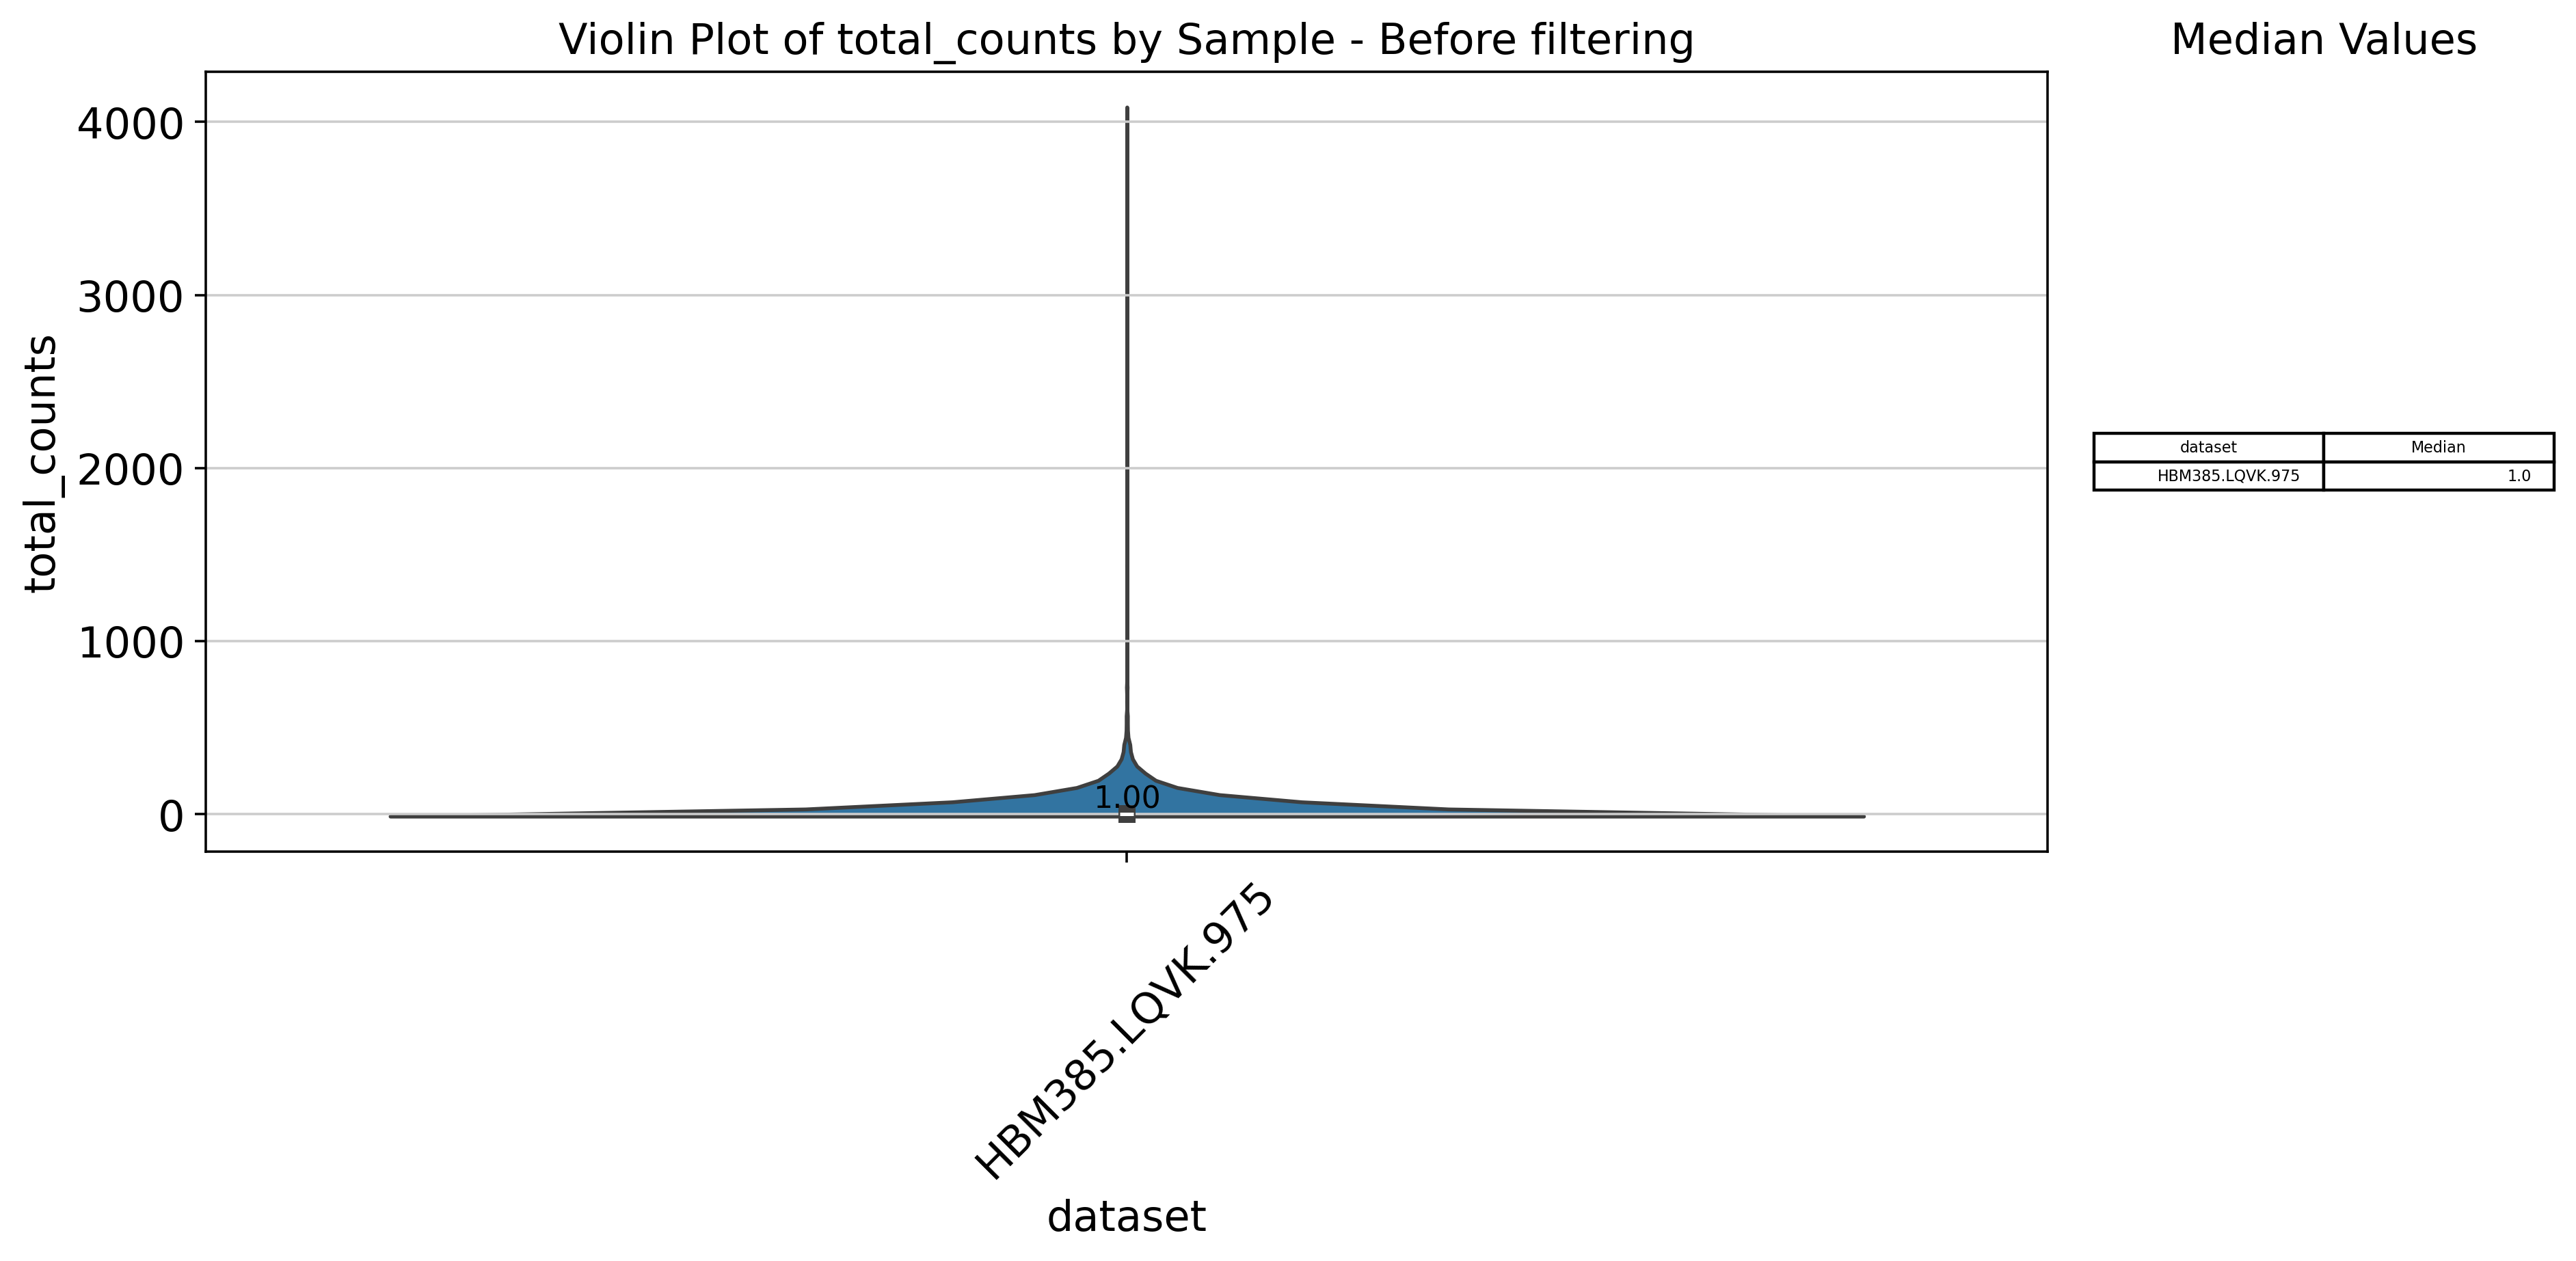

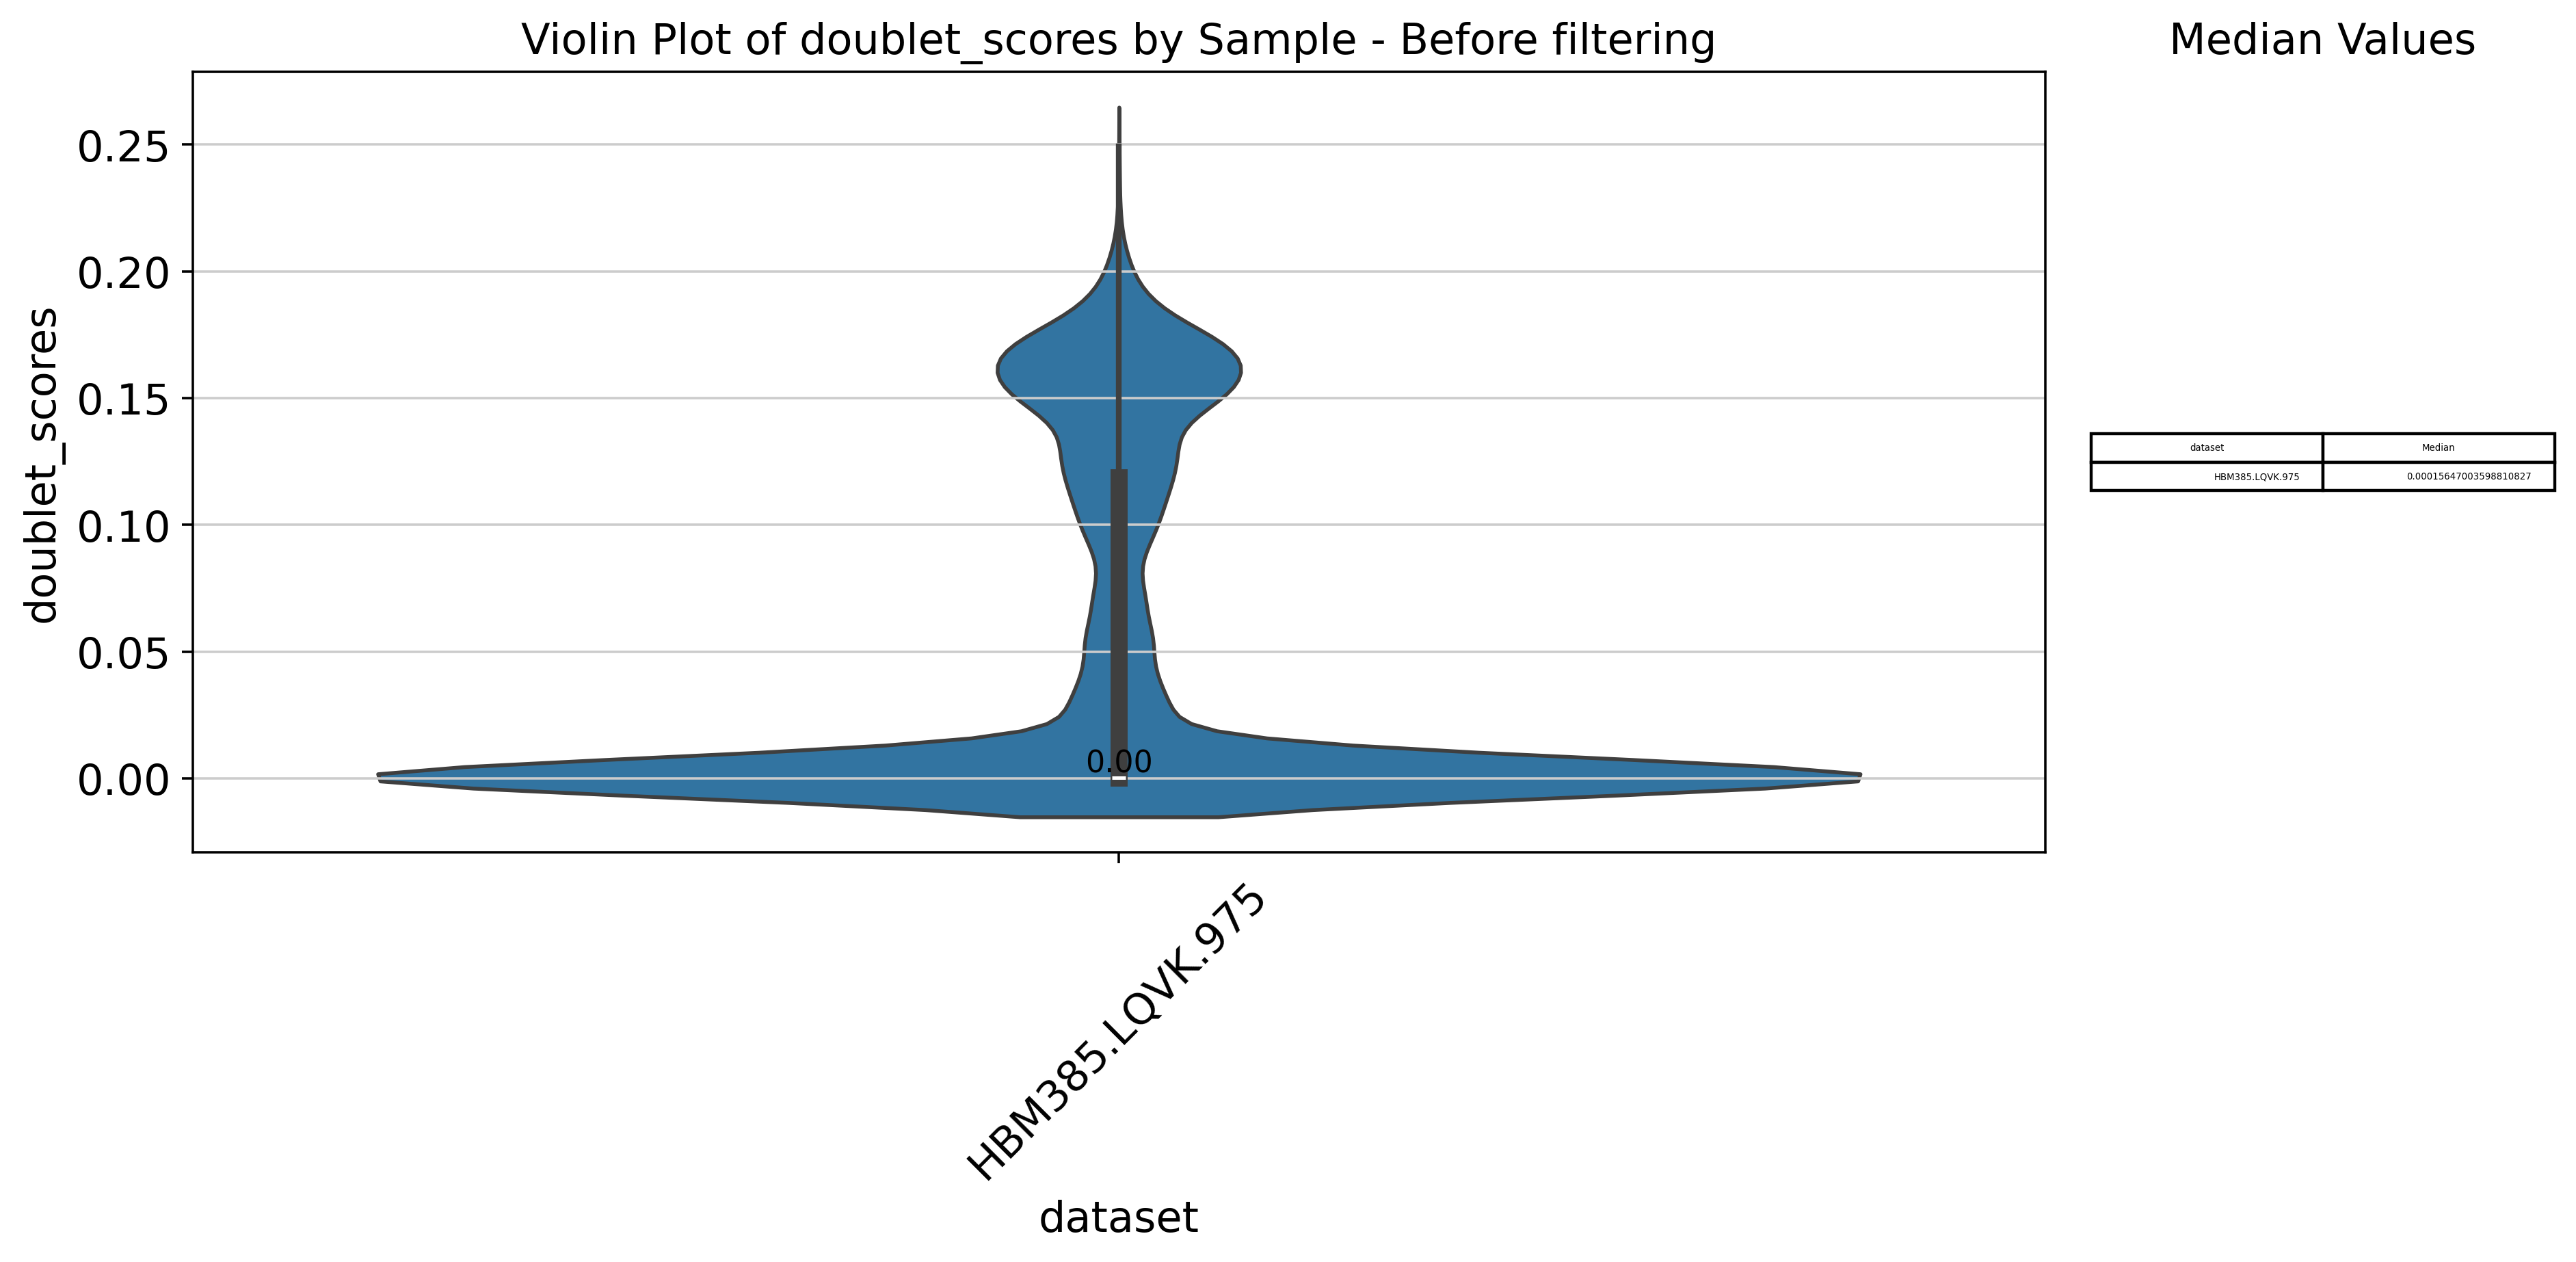

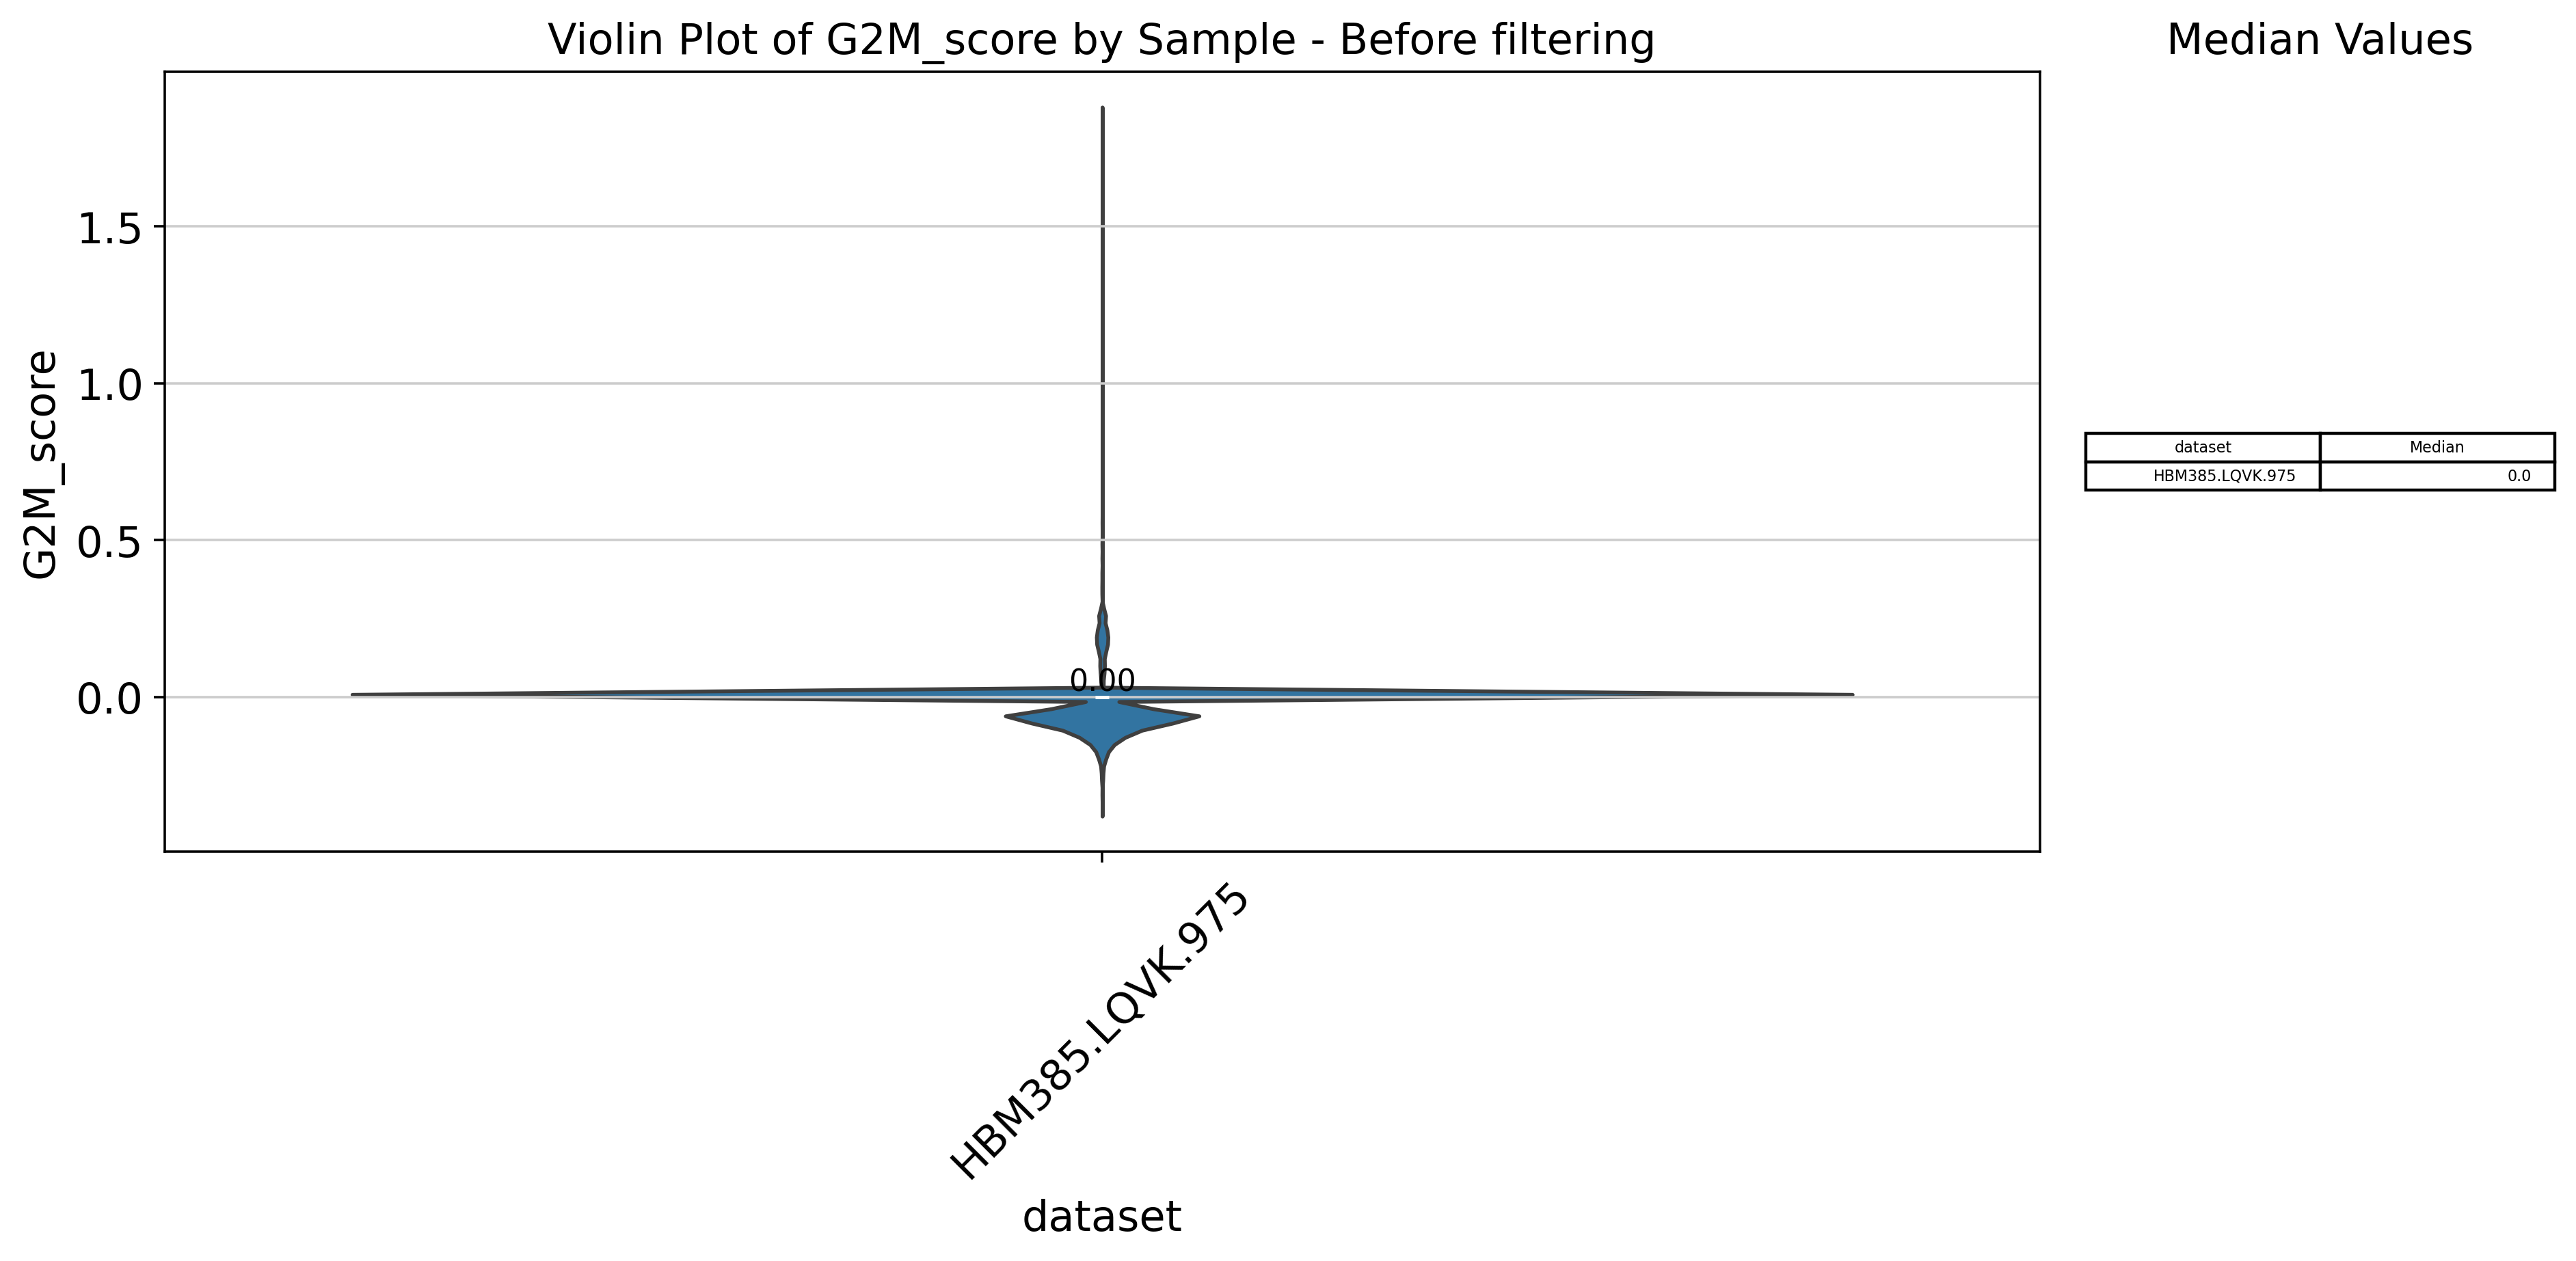

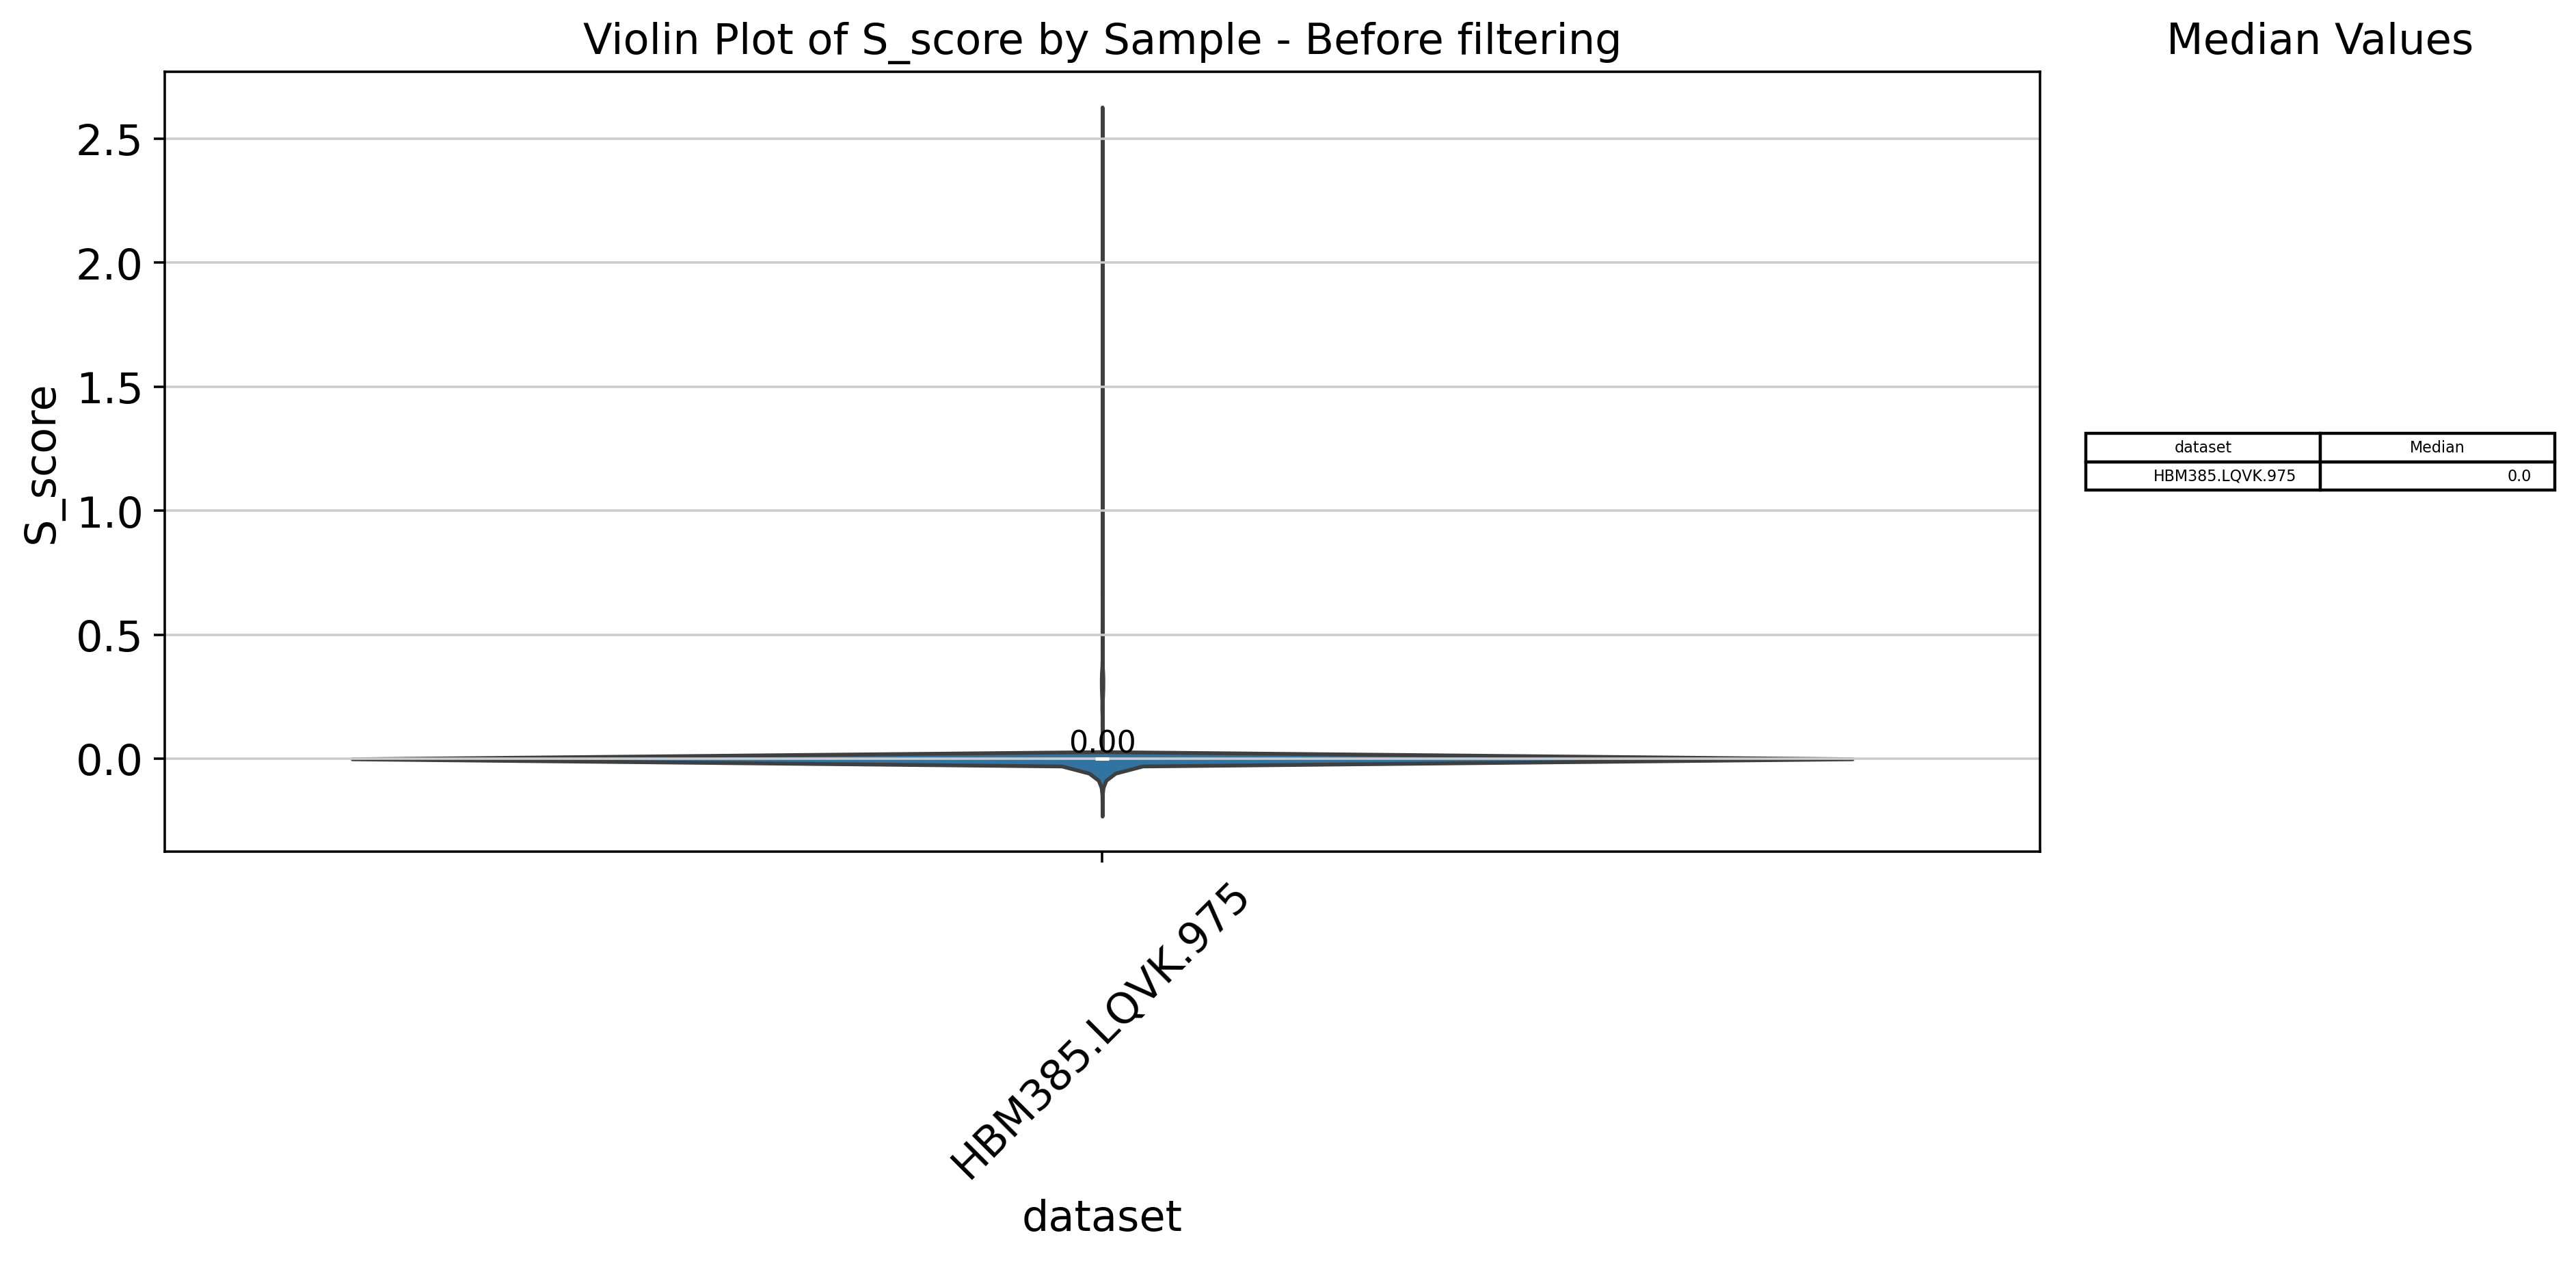

In [41]:
variables = 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'G2M_score', 'S_score'

for var in variables:

    fig, ax = plt.subplots(figsize=(12, 6), ncols=2, gridspec_kw={'width_ratios': [4, 1]})

    sb.violinplot(data=sample_object.obs,x = 'dataset' , y=var, ax=ax[0])
   
    medians = sample_object.obs.groupby('dataset')[var].median()

    for sample, median in medians.items():
        ax[0].text(sample, median, f'{median:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    
    ax[0].set_title(f'Violin Plot of {var} by Sample - Before filtering')
    ax[0].set_xlabel('dataset')
    ax[0].set_ylabel(var)
    ax[0].tick_params(axis='x', rotation=45)

    median_df = pd.DataFrame({'dataset': medians.index, 'Median': medians.values})

    ax[1].axis('off')
    ax[1].table(cellText=median_df.values, colLabels=median_df.columns, loc='center')
    ax[1].set_title('Median Values')
    
    plt.tight_layout()
    plt.show()


Text(0.5, 1.0, 'Mt and Ribo percentages - Before filtering')

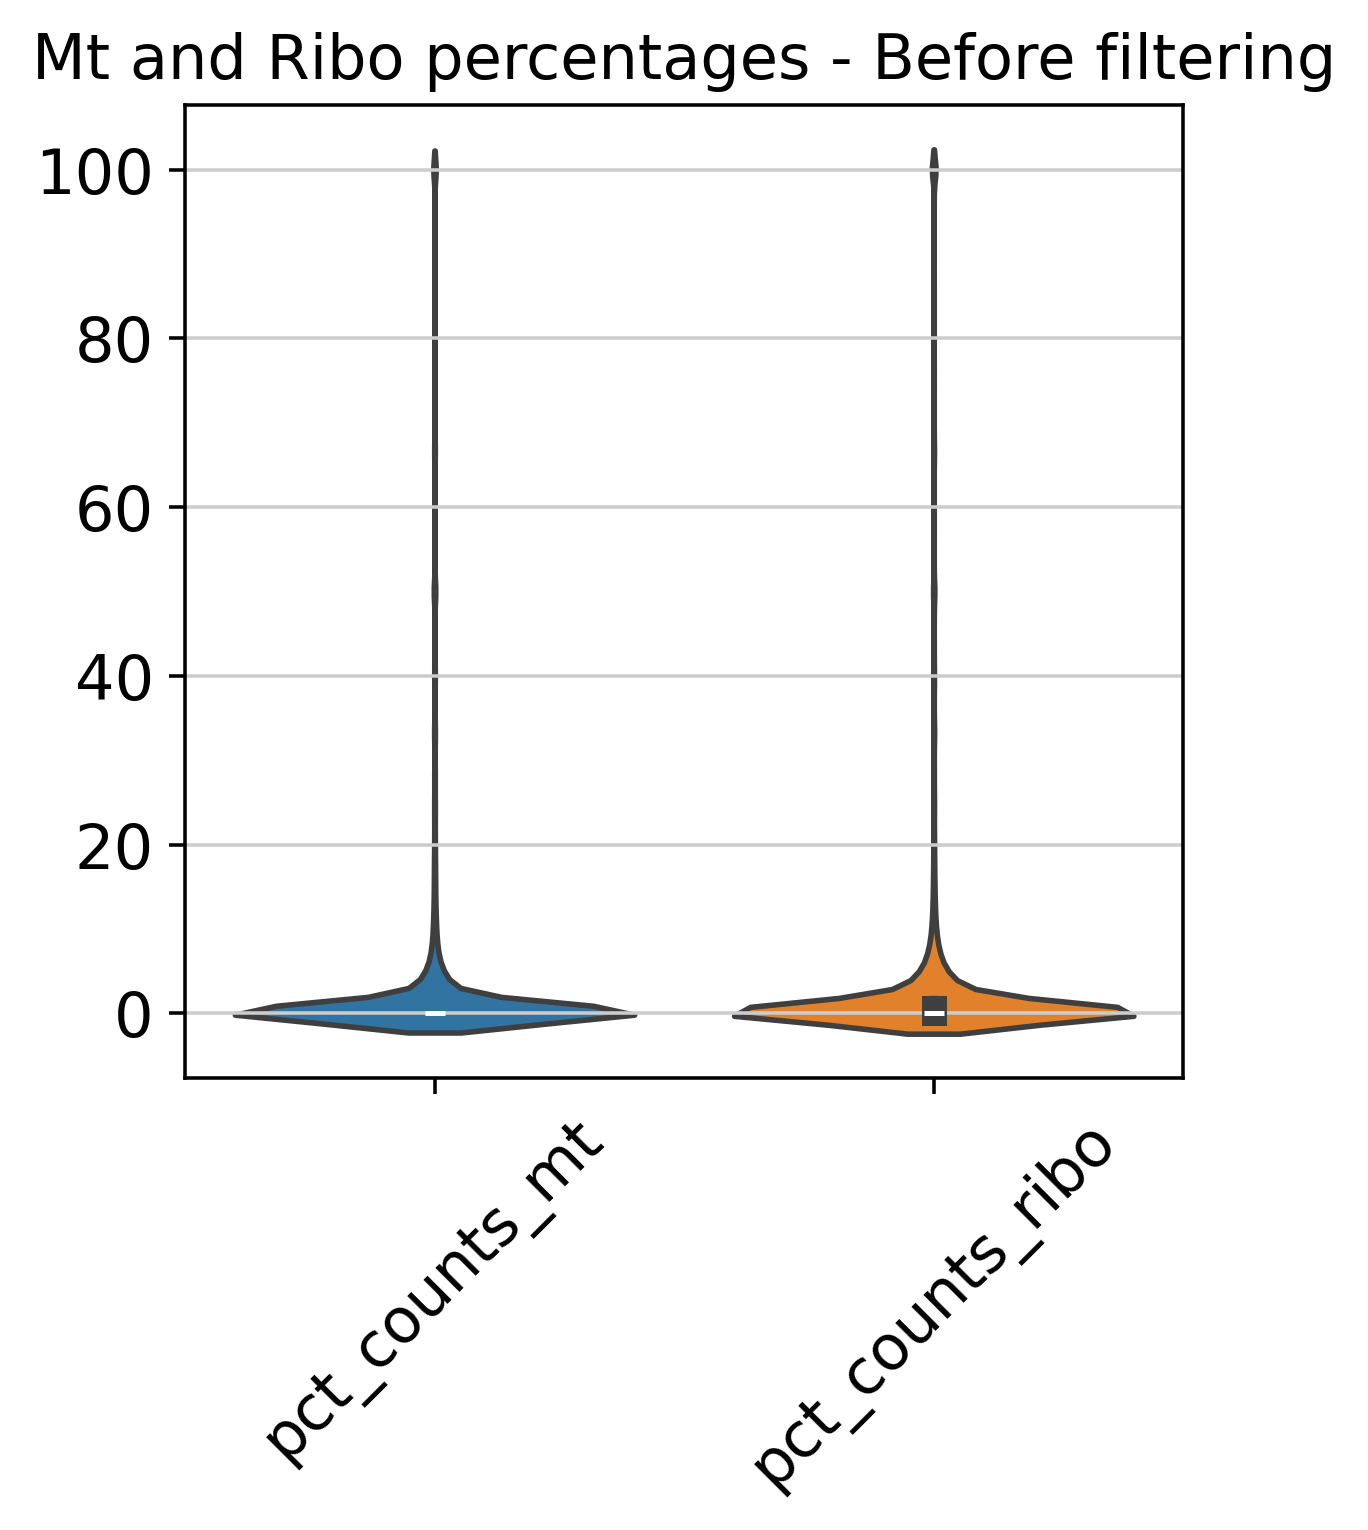

In [42]:
variables = ['pct_counts_mt', 'pct_counts_ribo']

sb.violinplot(data=sample_object.obs[variables])
plt.xticks(rotation=45)
plt.title(f'Mt and Ribo percentages - Before filtering')

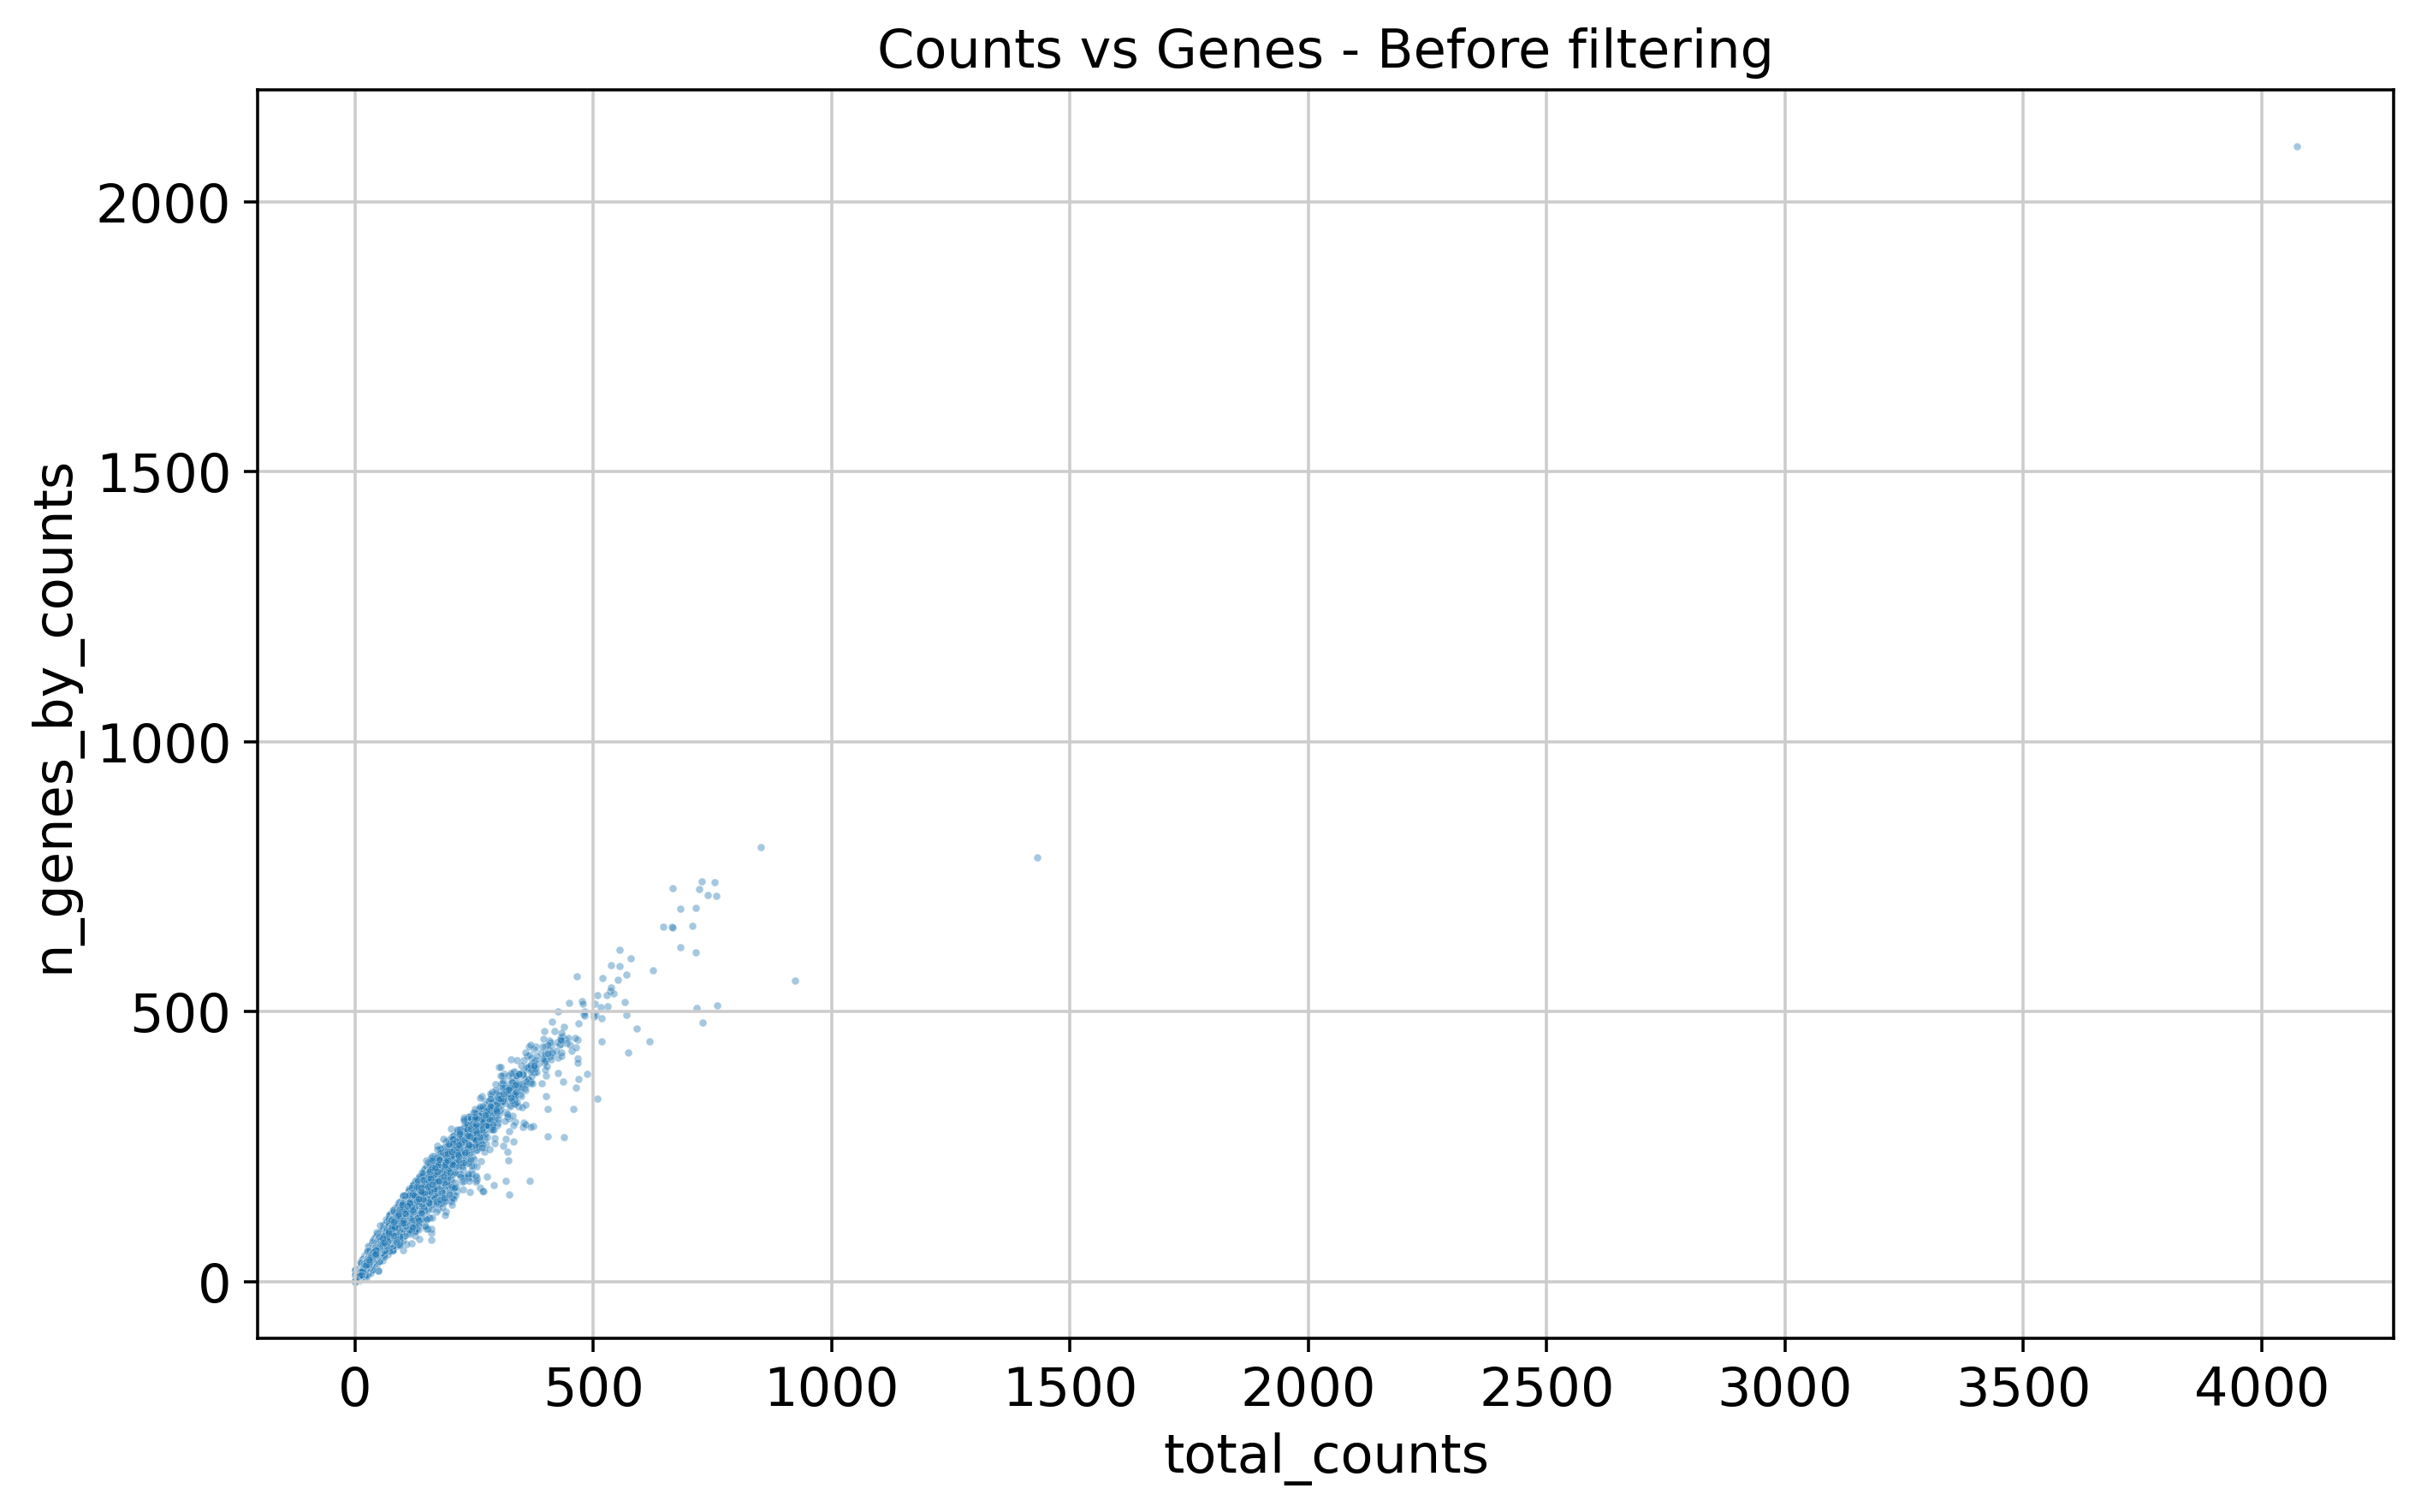

In [43]:
plt.figure(figsize=(10, 6))
sb.scatterplot(data=sample_object.obs, x='total_counts', y='n_genes_by_counts' , alpha = 0.4, s=4)
#plt.xticks(range(0, int(max(sample_object.obs['total_counts'])) + 1, 3000),rotation=45, fontsize = 10)
#plt.yticks(range(0, int(max(sample_object.obs['n_genes_by_counts'])) + 1, 1000),fontsize = 10)
plt.title(f'Counts vs Genes - Before filtering')
plt.show()

### Filtering based on QC metrics

In [44]:
filtered_object = sample_object[sample_object.obs['n_genes_by_counts'] > 20]
filtered_object = filtered_object[filtered_object.obs['n_genes_by_counts'] < 500]

filtered_object = filtered_object[filtered_object.obs['total_counts'] > 20]
filtered_object = filtered_object[filtered_object.obs['total_counts'] < 500]

filtered_object = filtered_object[filtered_object.obs['pct_counts_mt'] < 60]
filtered_object = filtered_object[filtered_object.obs['pct_counts_ribo'] < 20]

filtered_object = filtered_object[filtered_object.obs['doublet_scores'] < 0.35]

filtered_object

View of AnnData object with n_obs × n_vars = 10720 × 60286
    obs: 'cell_id', 'dataset', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'hugo_symbol', 'ensembl', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'corrected_ensembl'
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced'

Text(0.5, 1.0, 'Mt and Ribo percentages - After filtering')

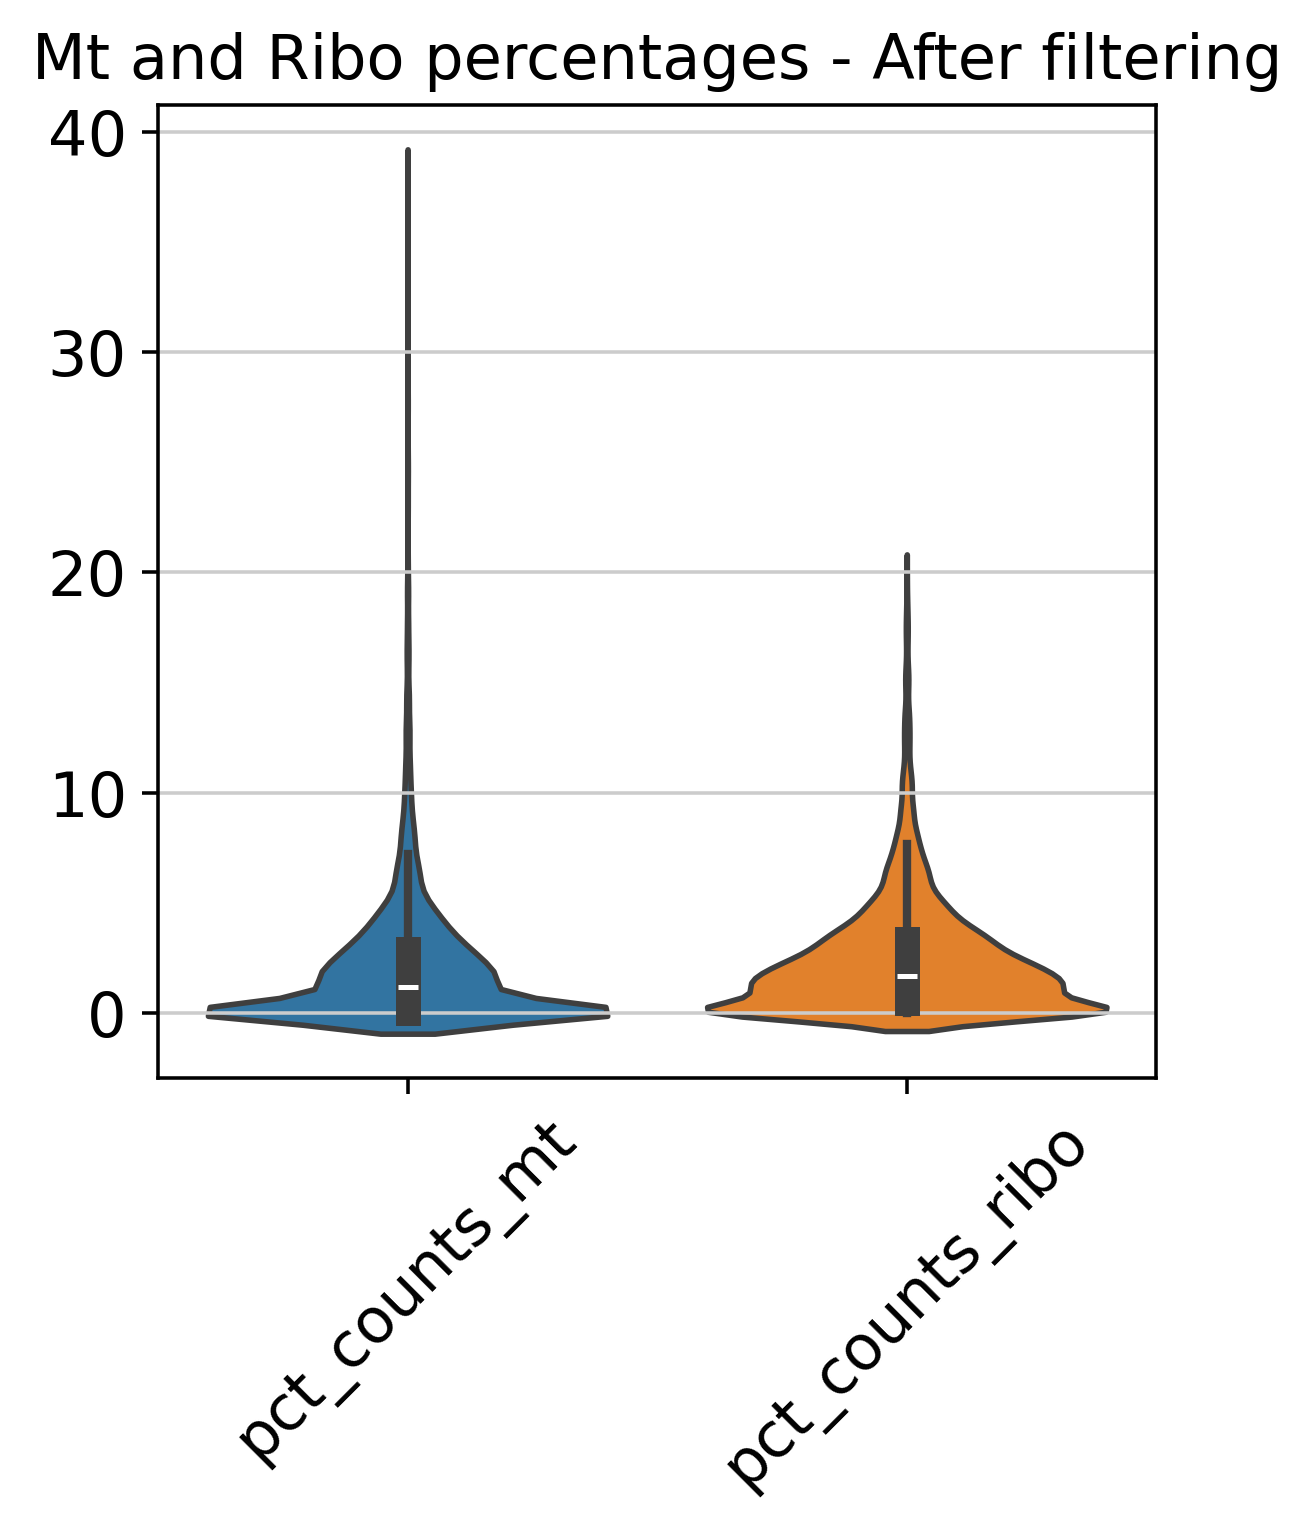

In [45]:
variables = ['pct_counts_mt', 'pct_counts_ribo']

sb.violinplot(data=filtered_object.obs[variables])
plt.xticks(rotation=45)
plt.title(f'Mt and Ribo percentages - After filtering')

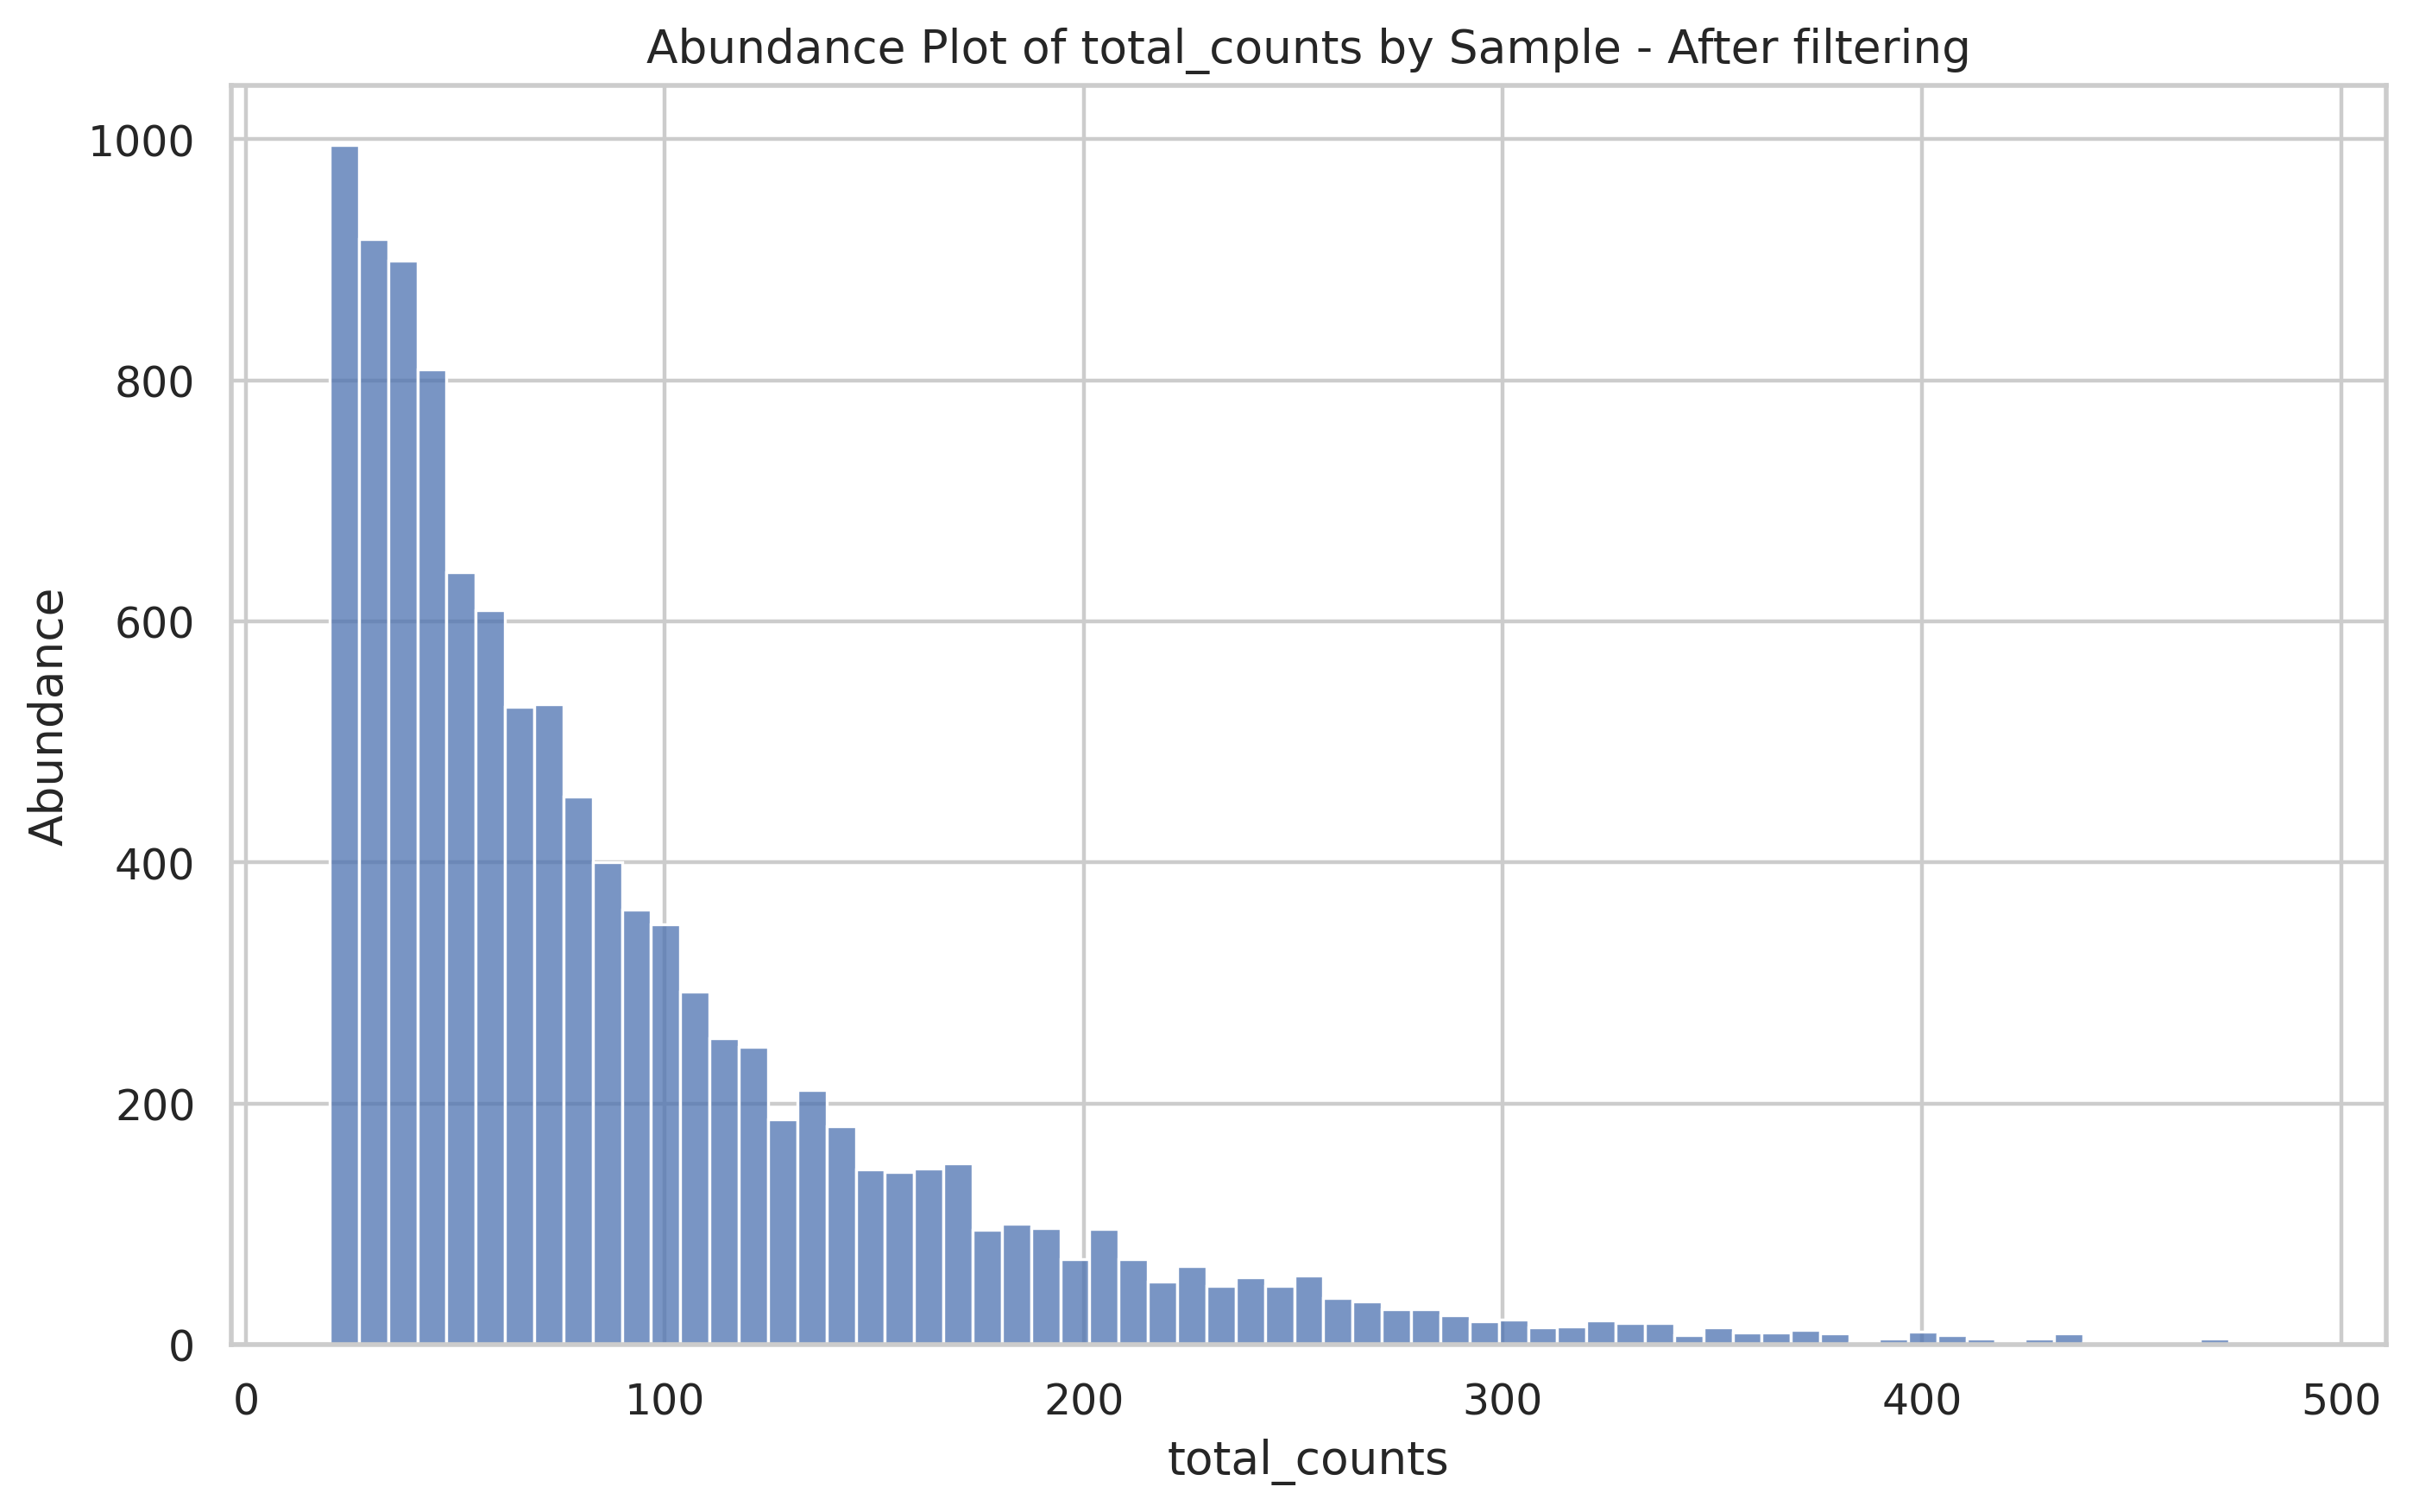

In [46]:
sb.set(style = "whitegrid")
covariate_to_visualize = 'total_counts'

plt.figure(figsize = (10, 6))
sb.histplot(data = filtered_object.obs, x = covariate_to_visualize, stat = 'count', common_norm = False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Sample - After filtering')
plt.show()

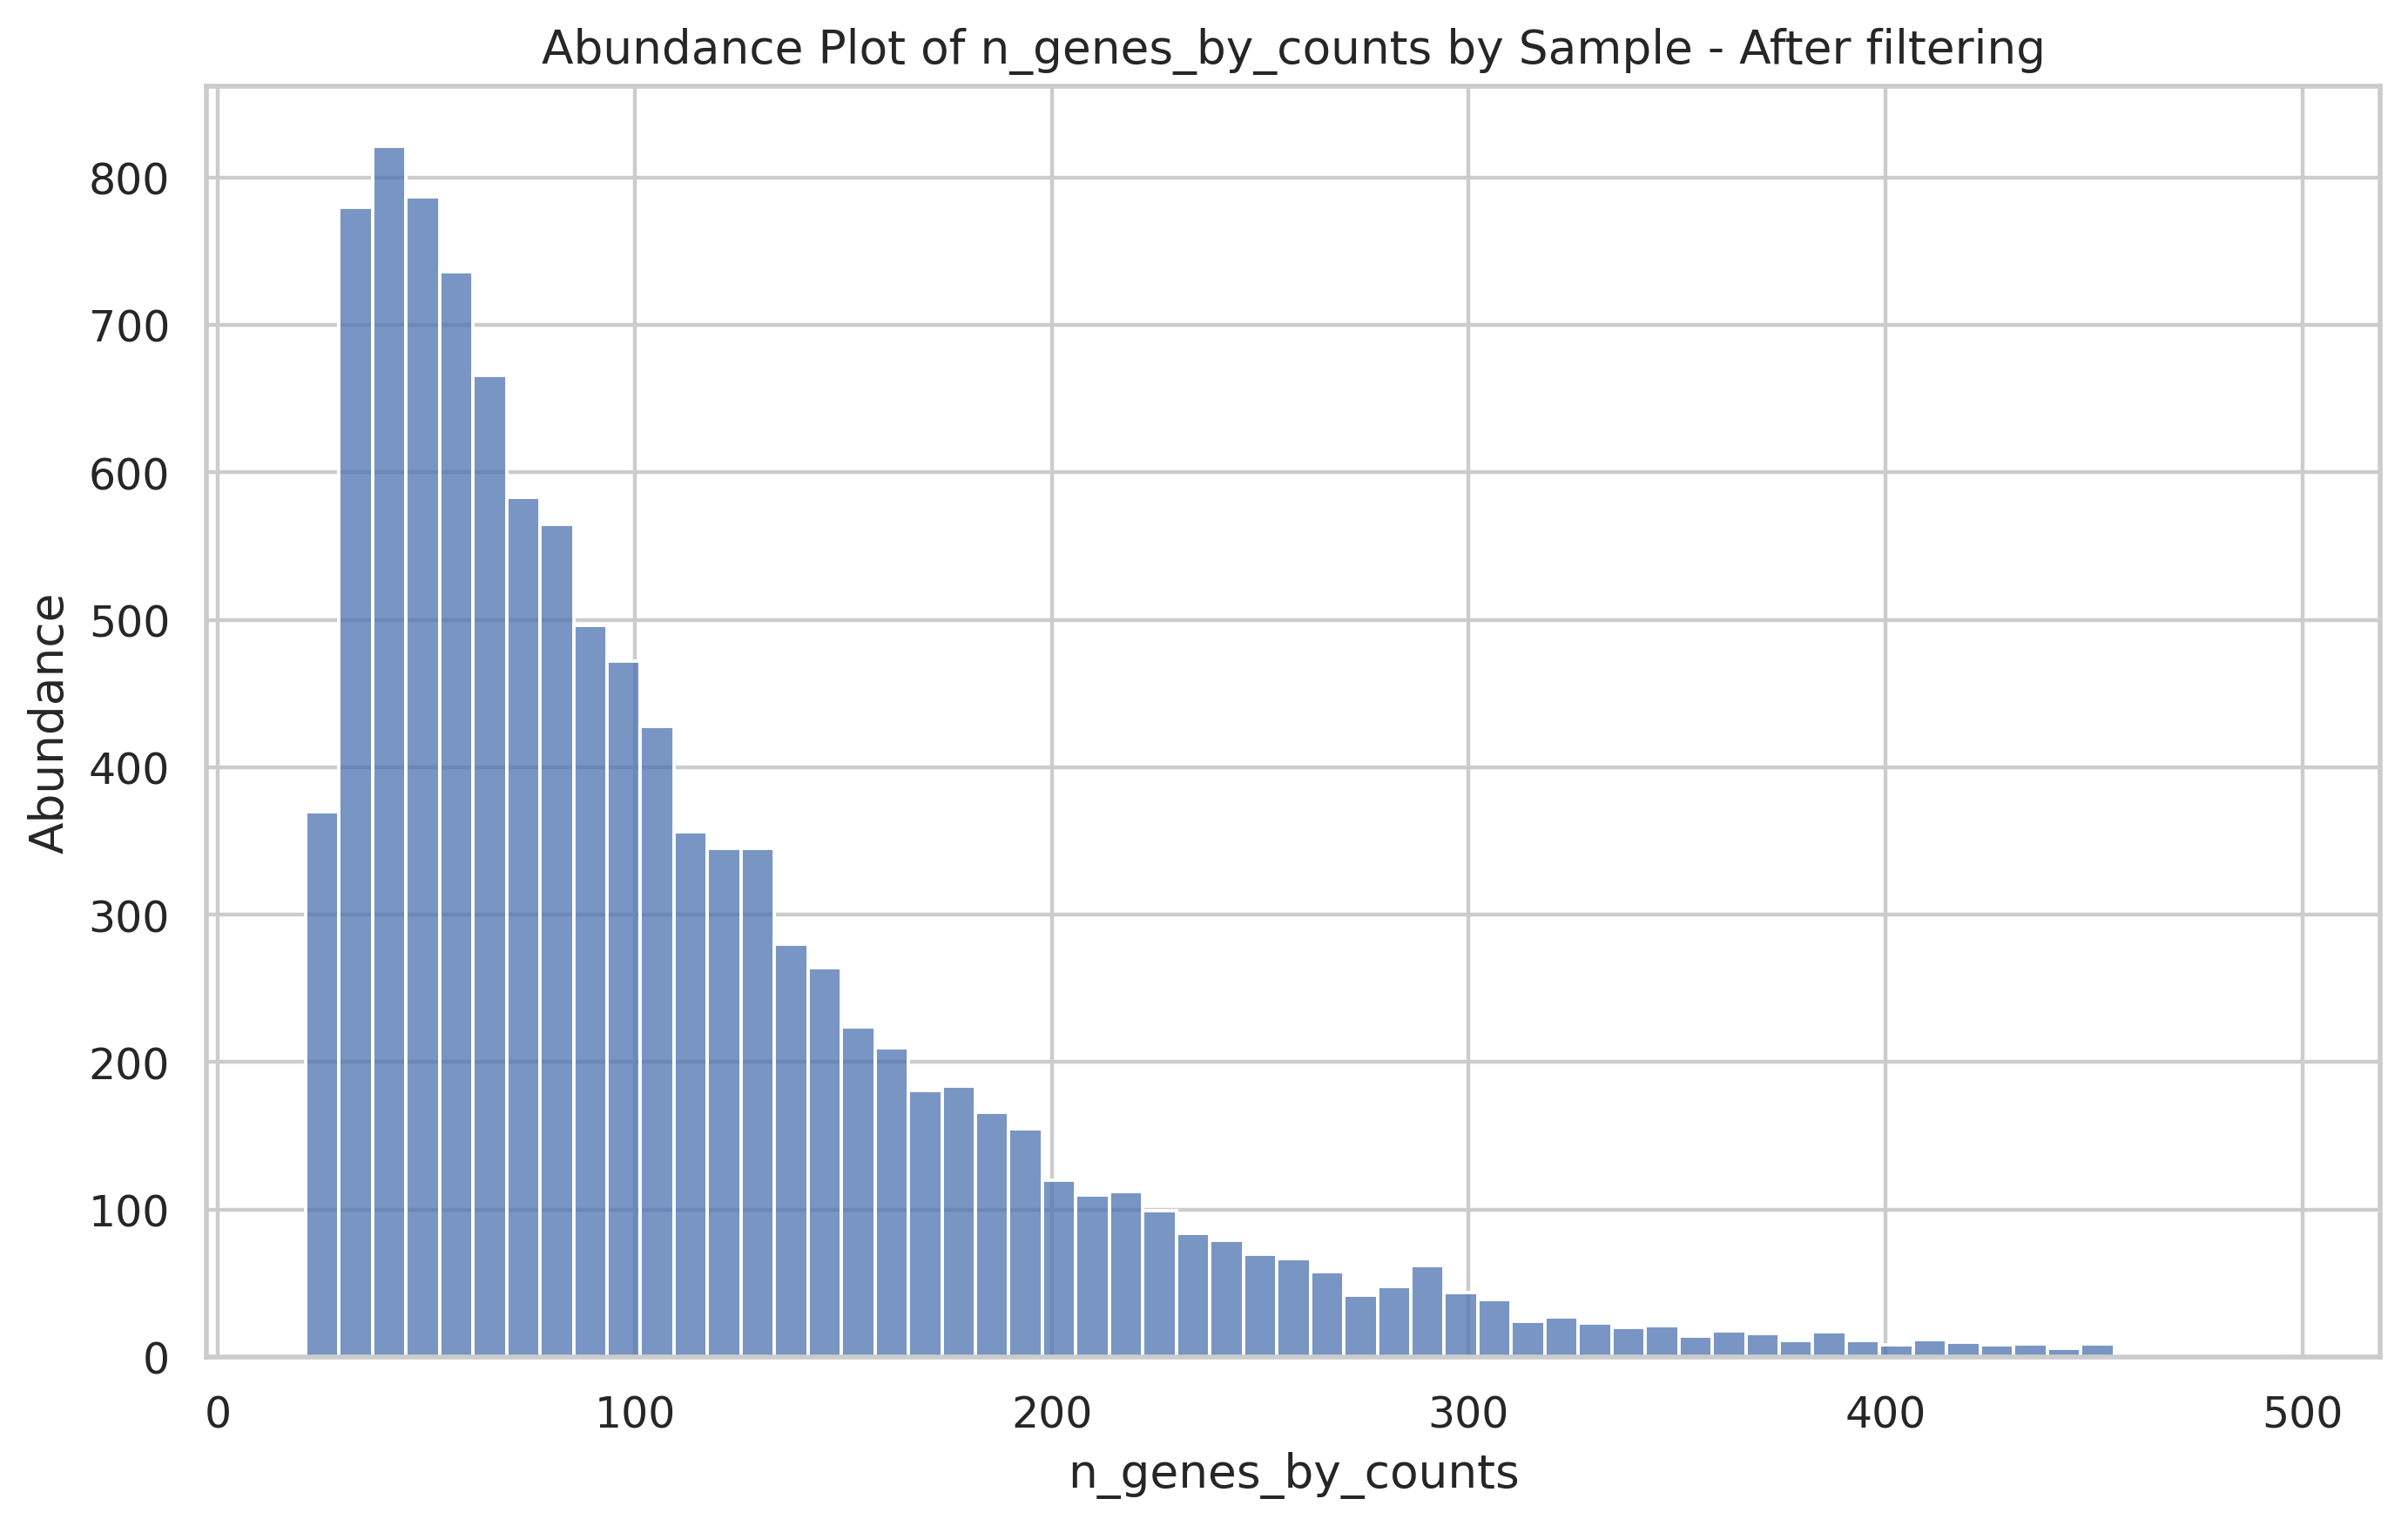

In [47]:
sb.set(style = "whitegrid")
covariate_to_visualize = 'n_genes_by_counts'

plt.figure(figsize = (10, 6))
sb.histplot(data = filtered_object.obs, x = covariate_to_visualize, stat = 'count', common_norm = False)
plt.xlabel(covariate_to_visualize)
plt.ylabel('Abundance')
plt.title(f'Abundance Plot of {covariate_to_visualize} by Sample - After filtering')
plt.show()

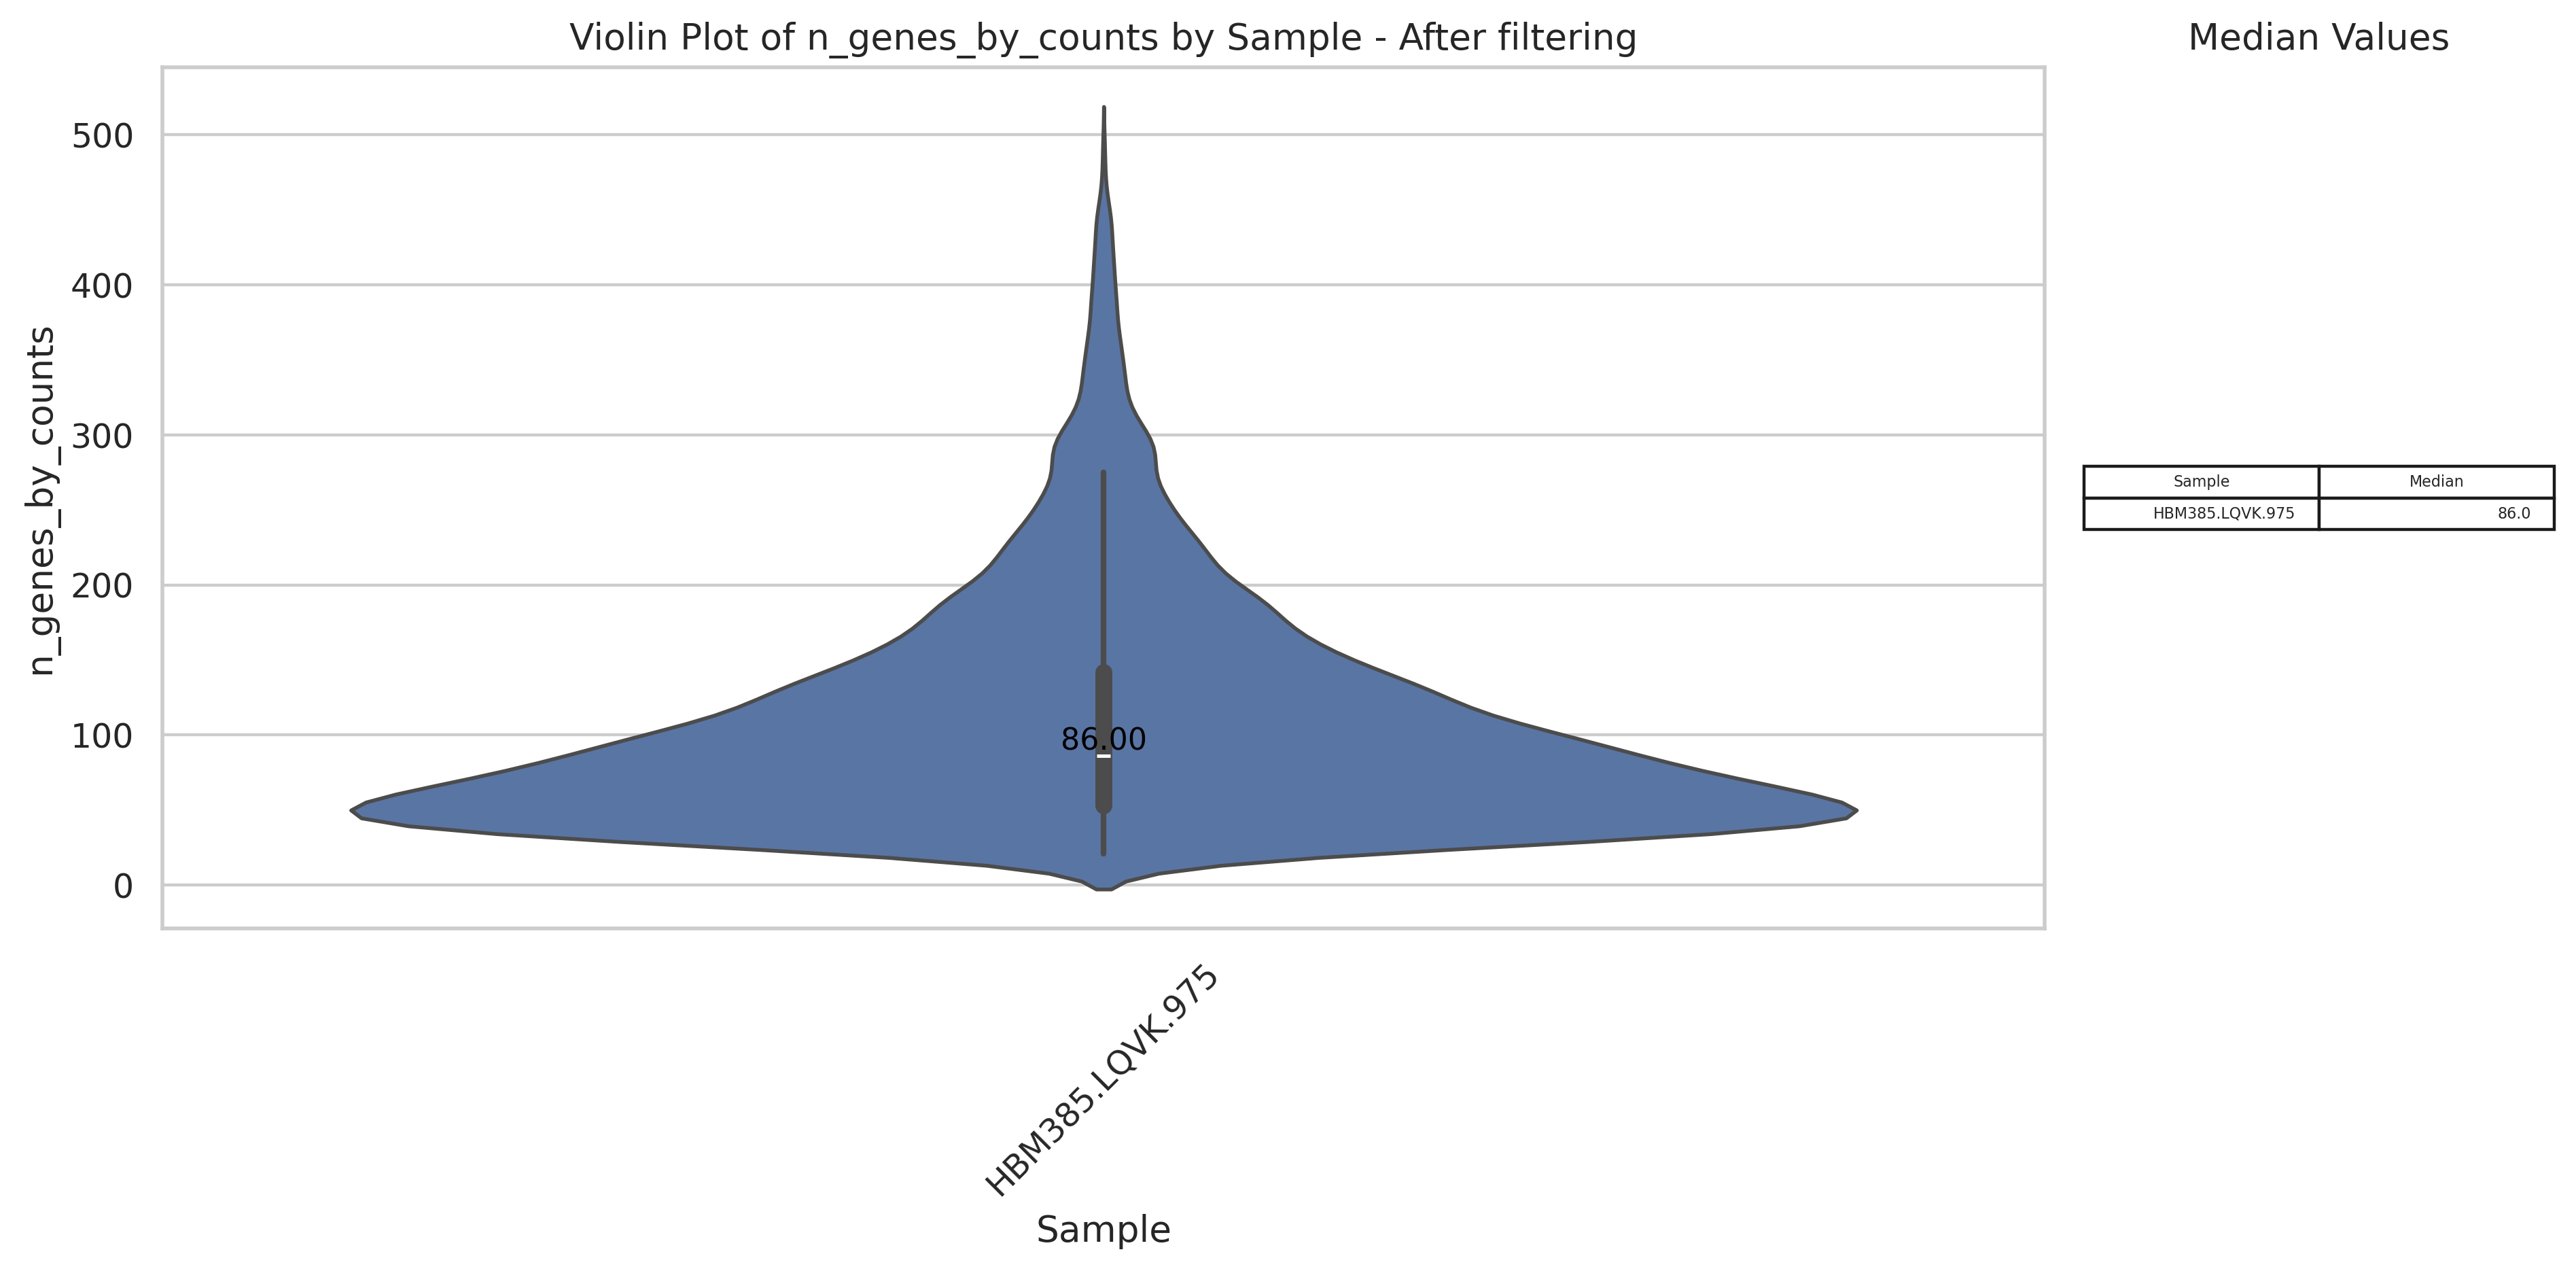

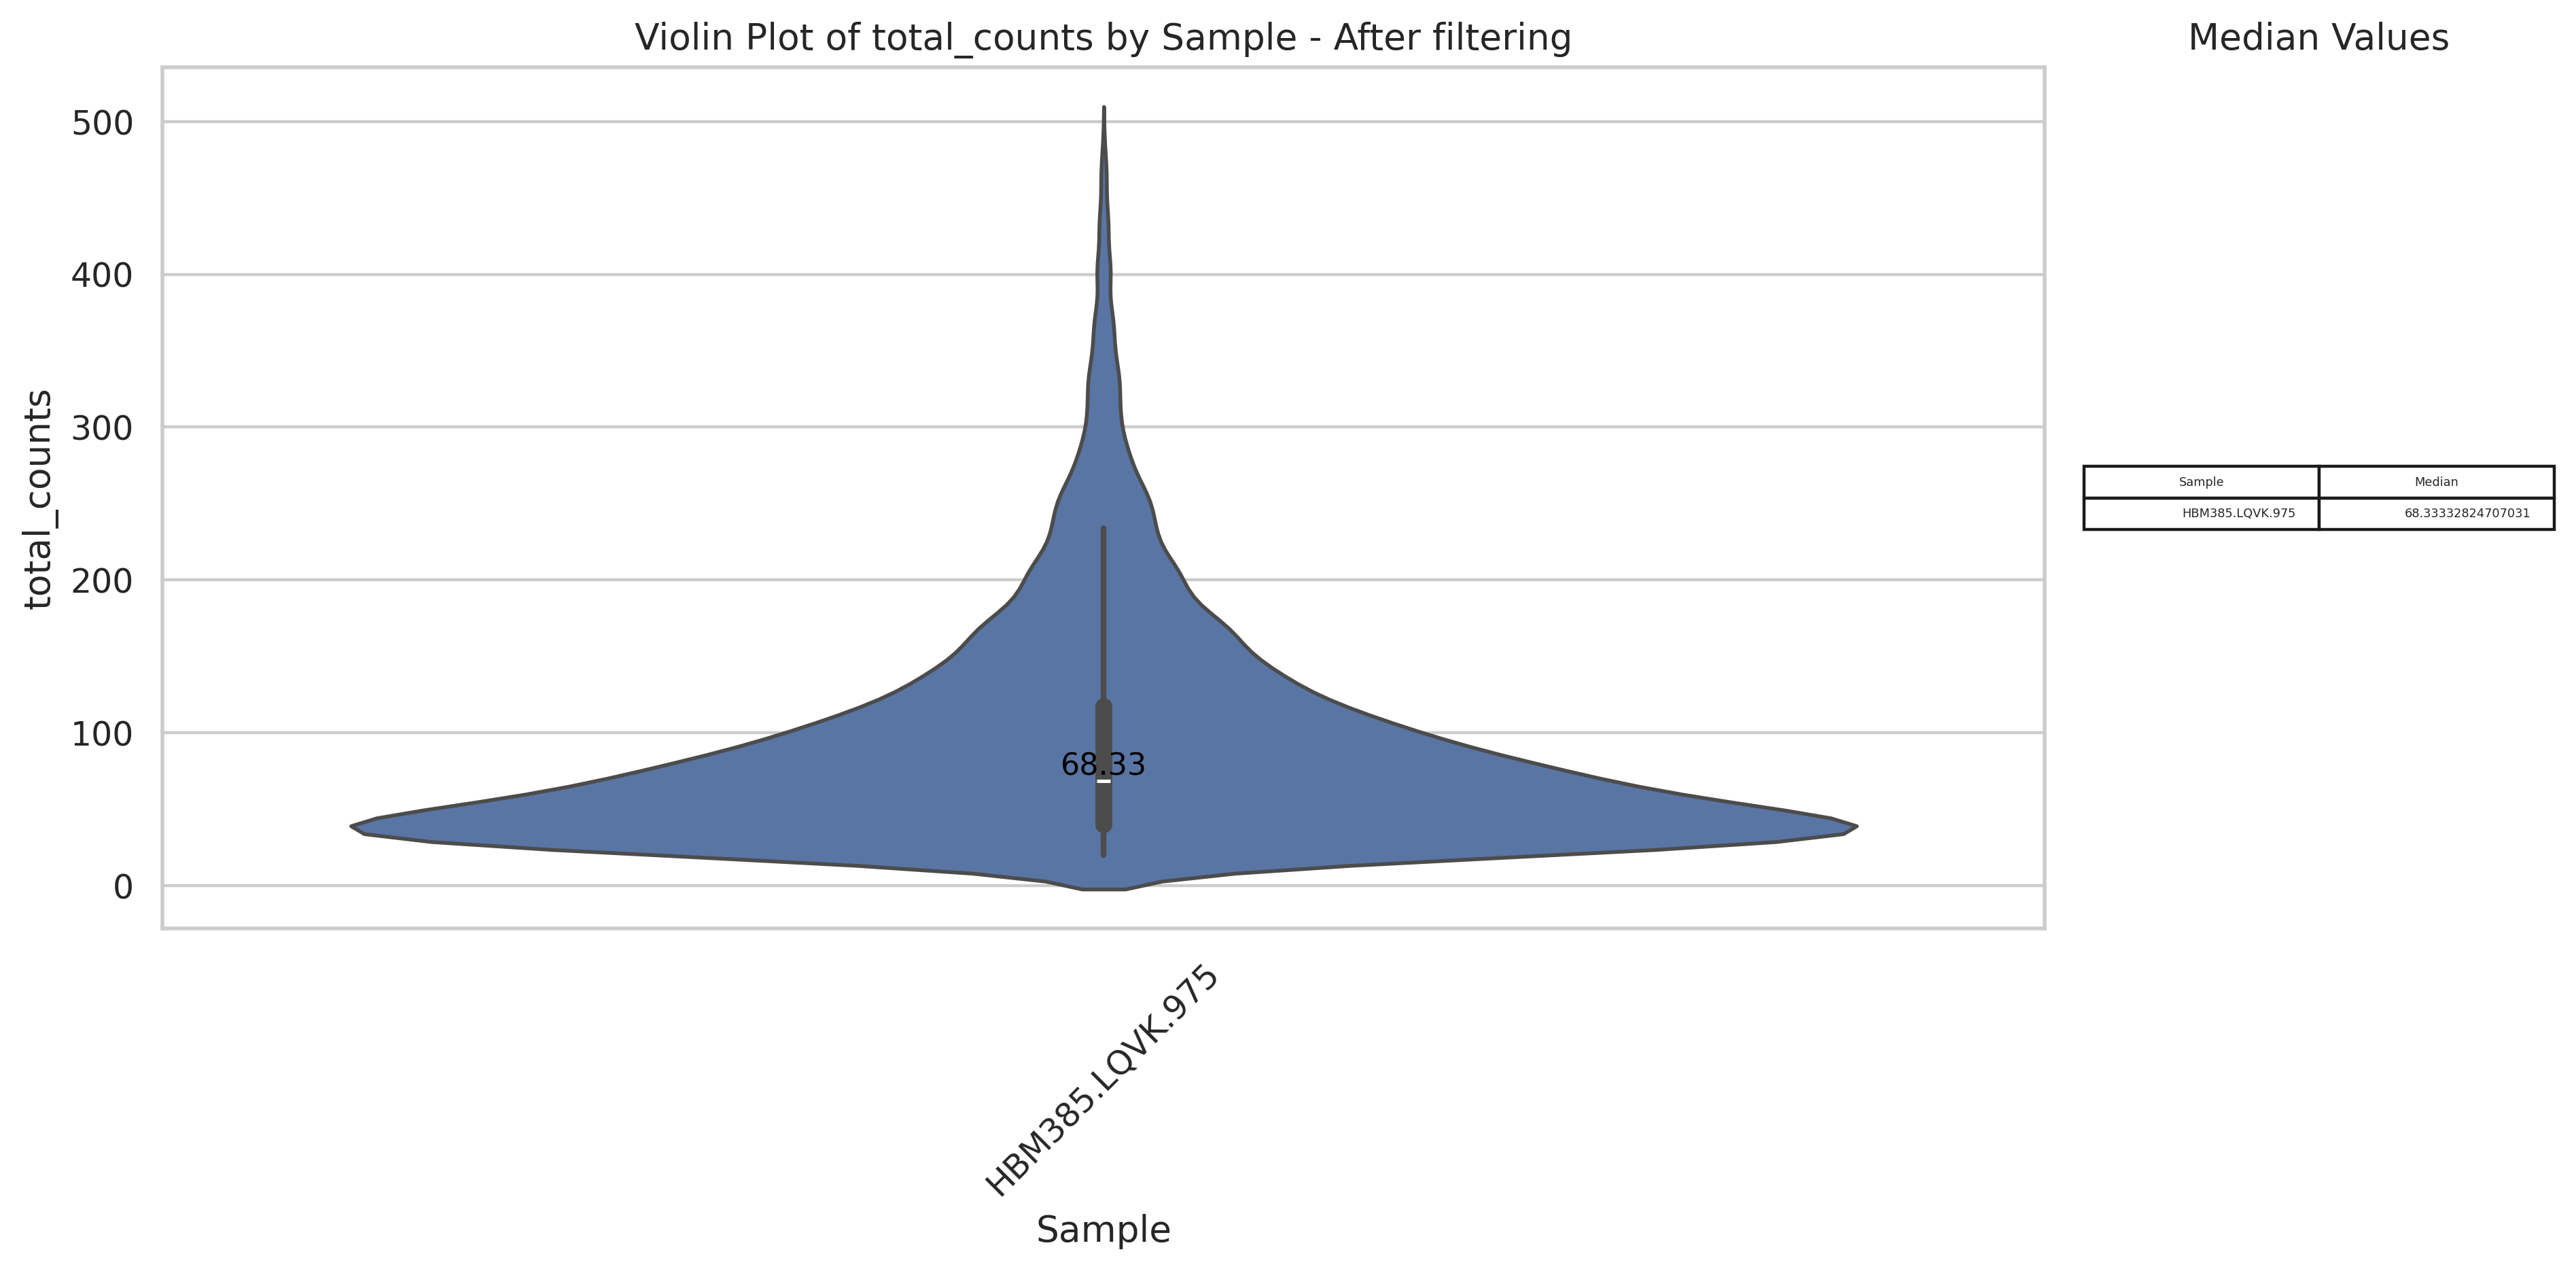

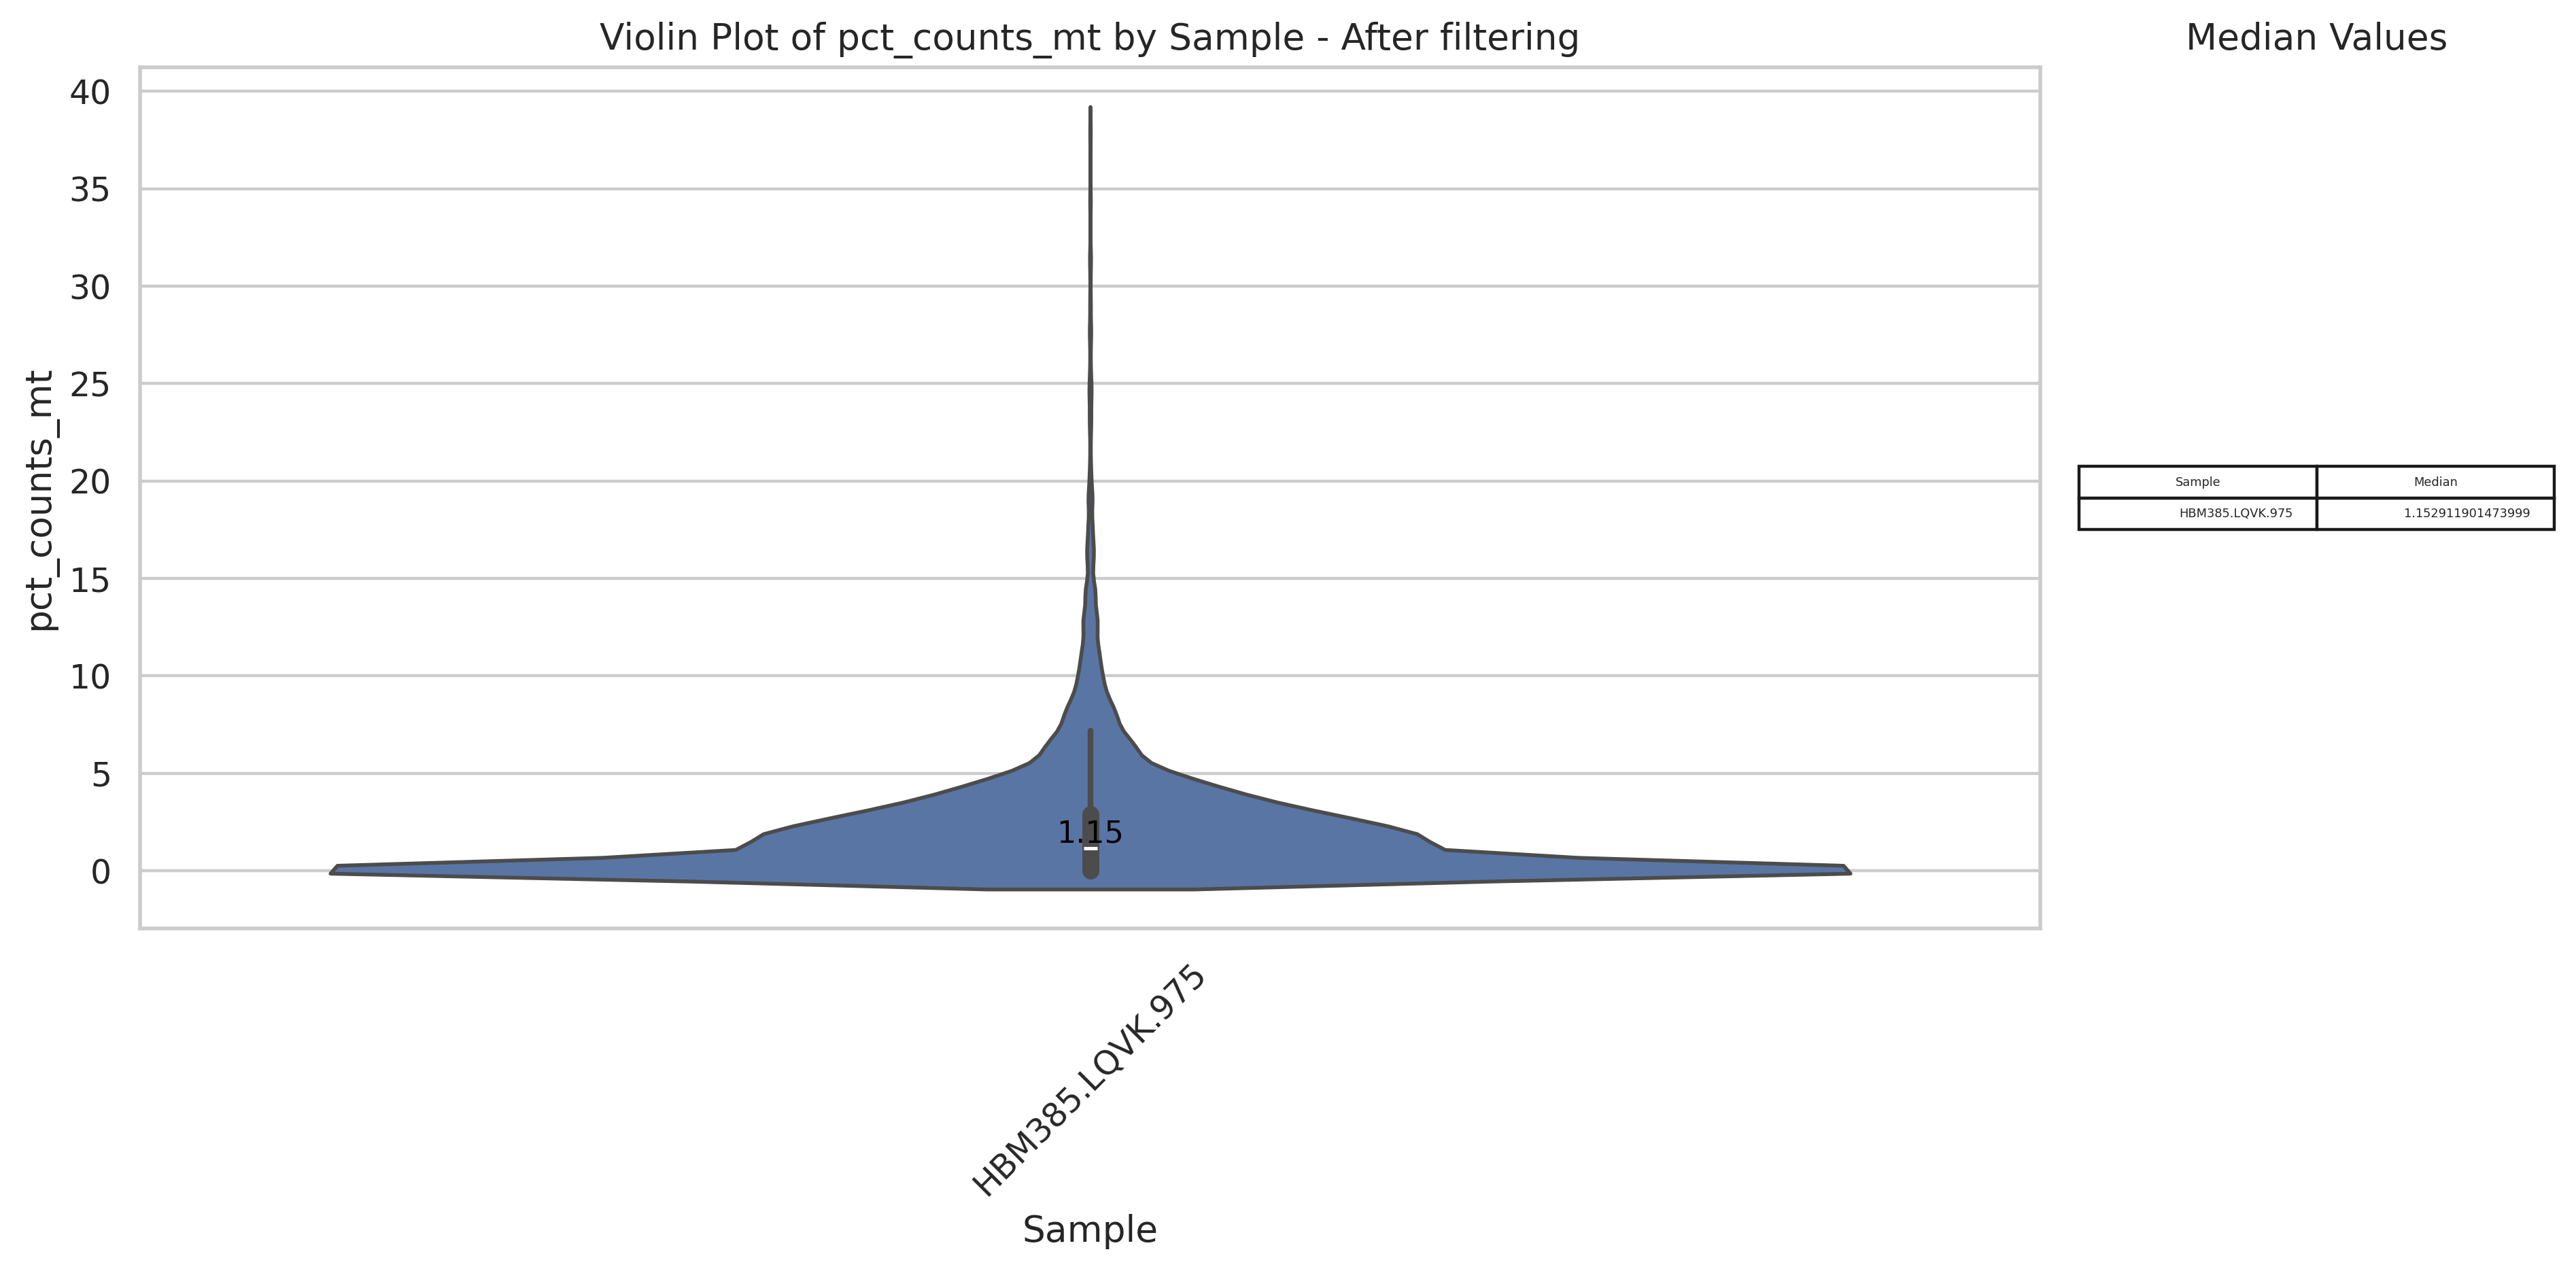

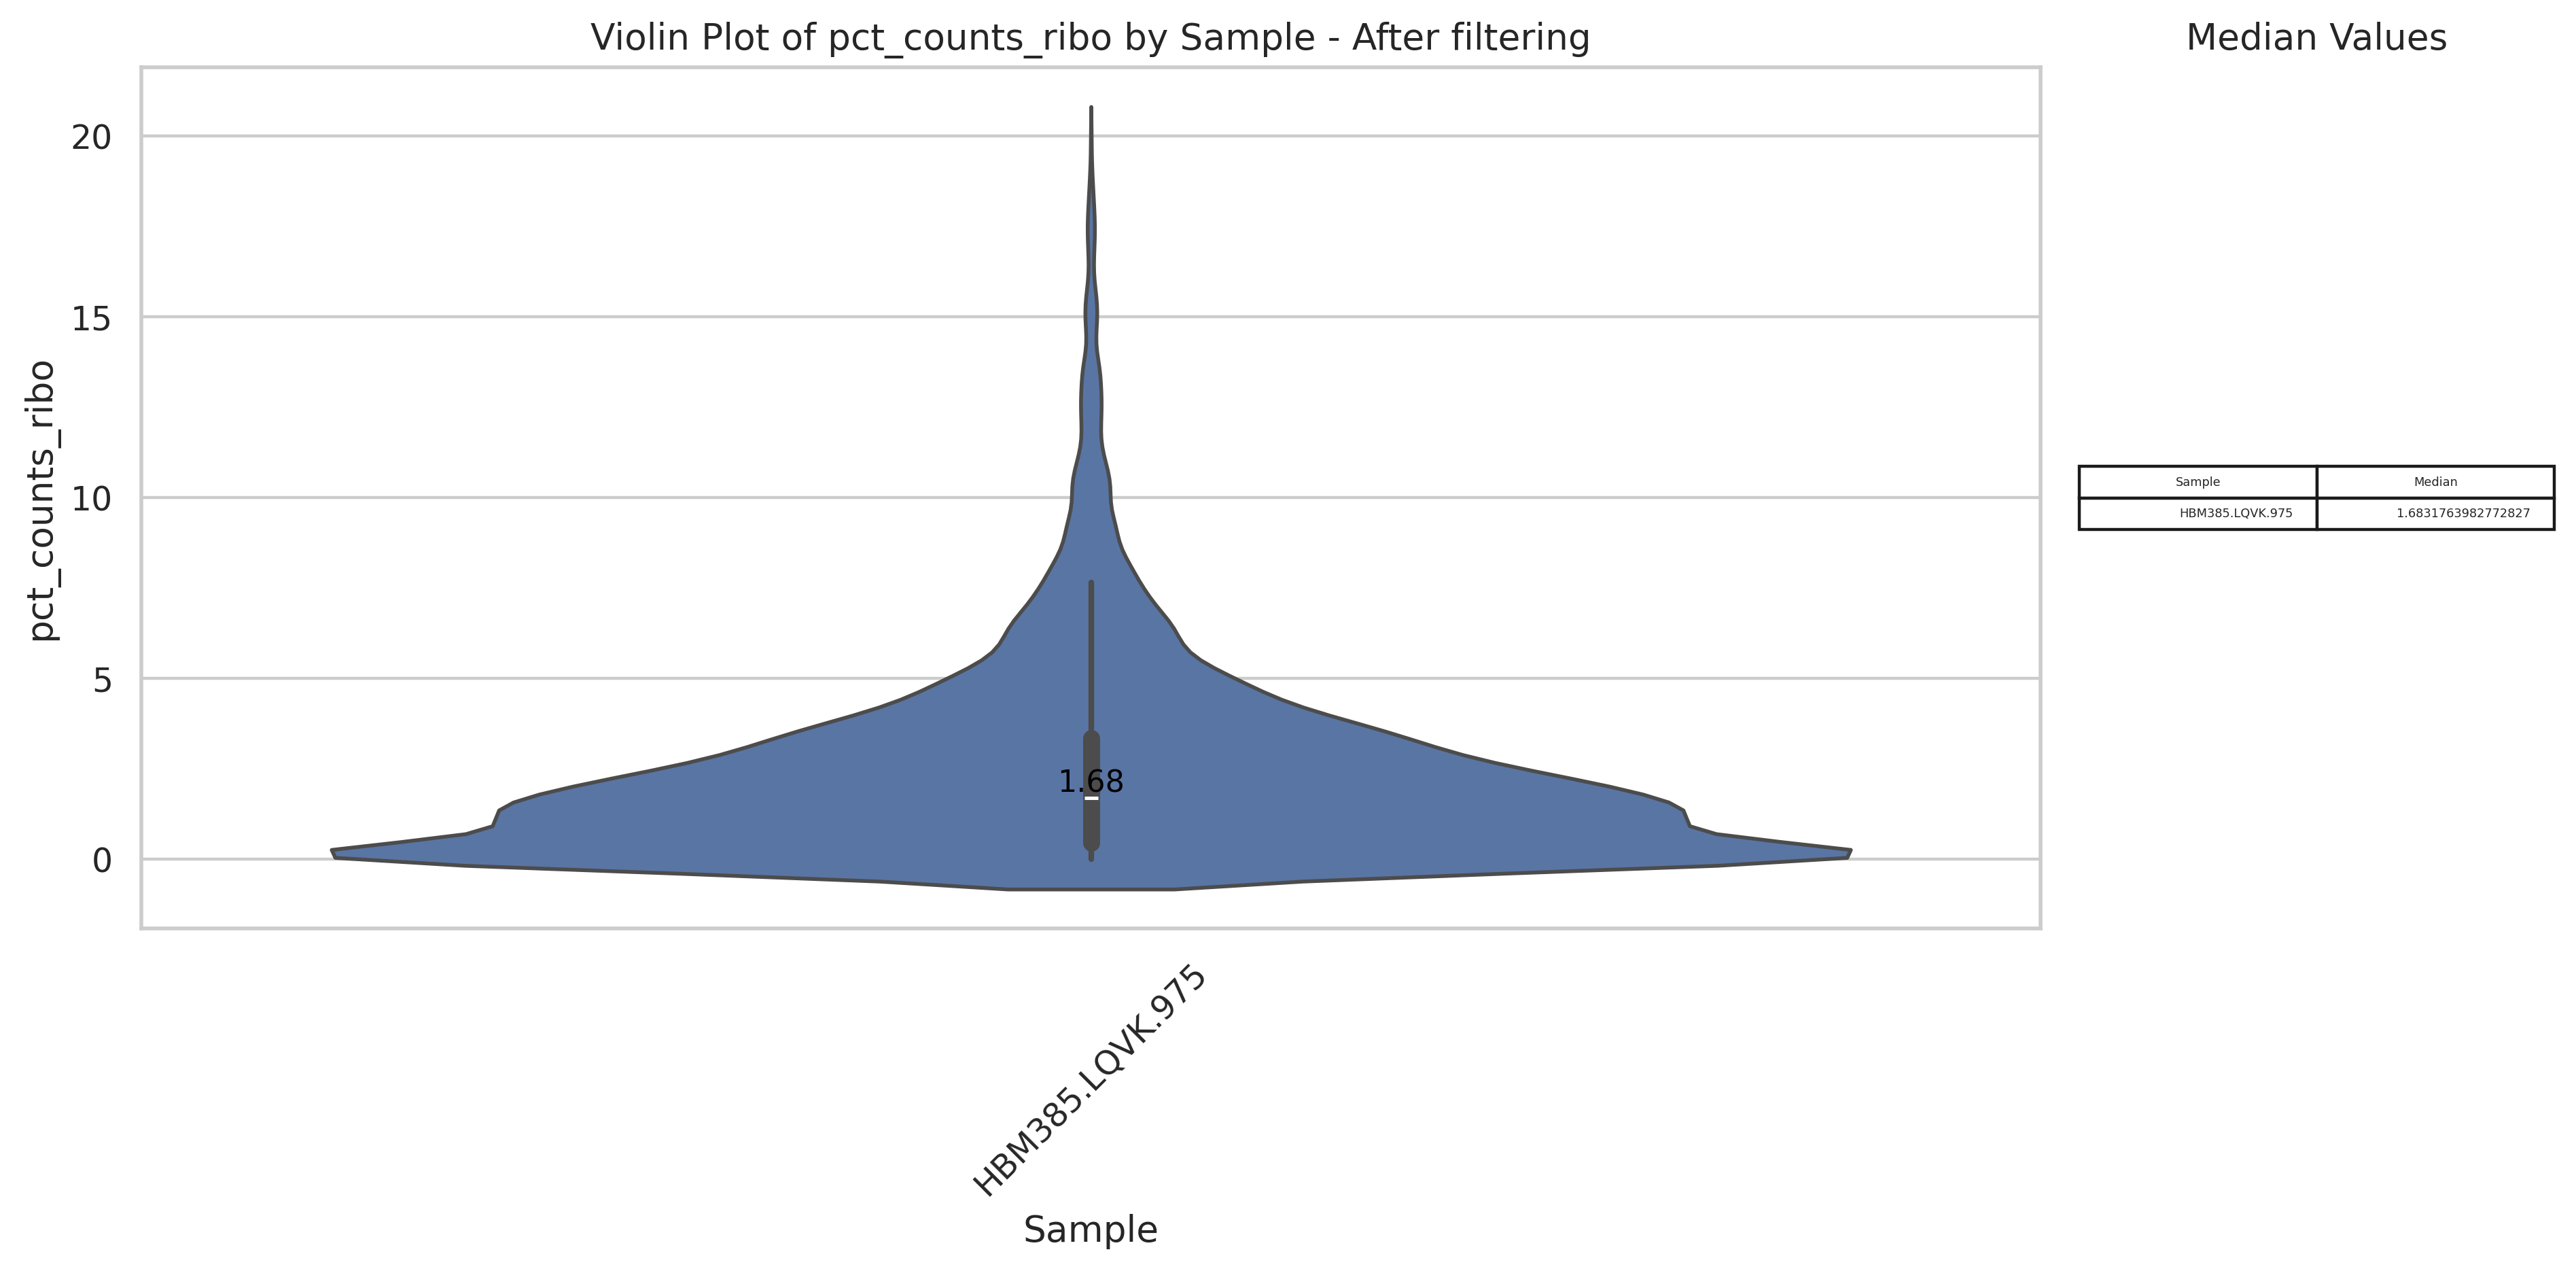

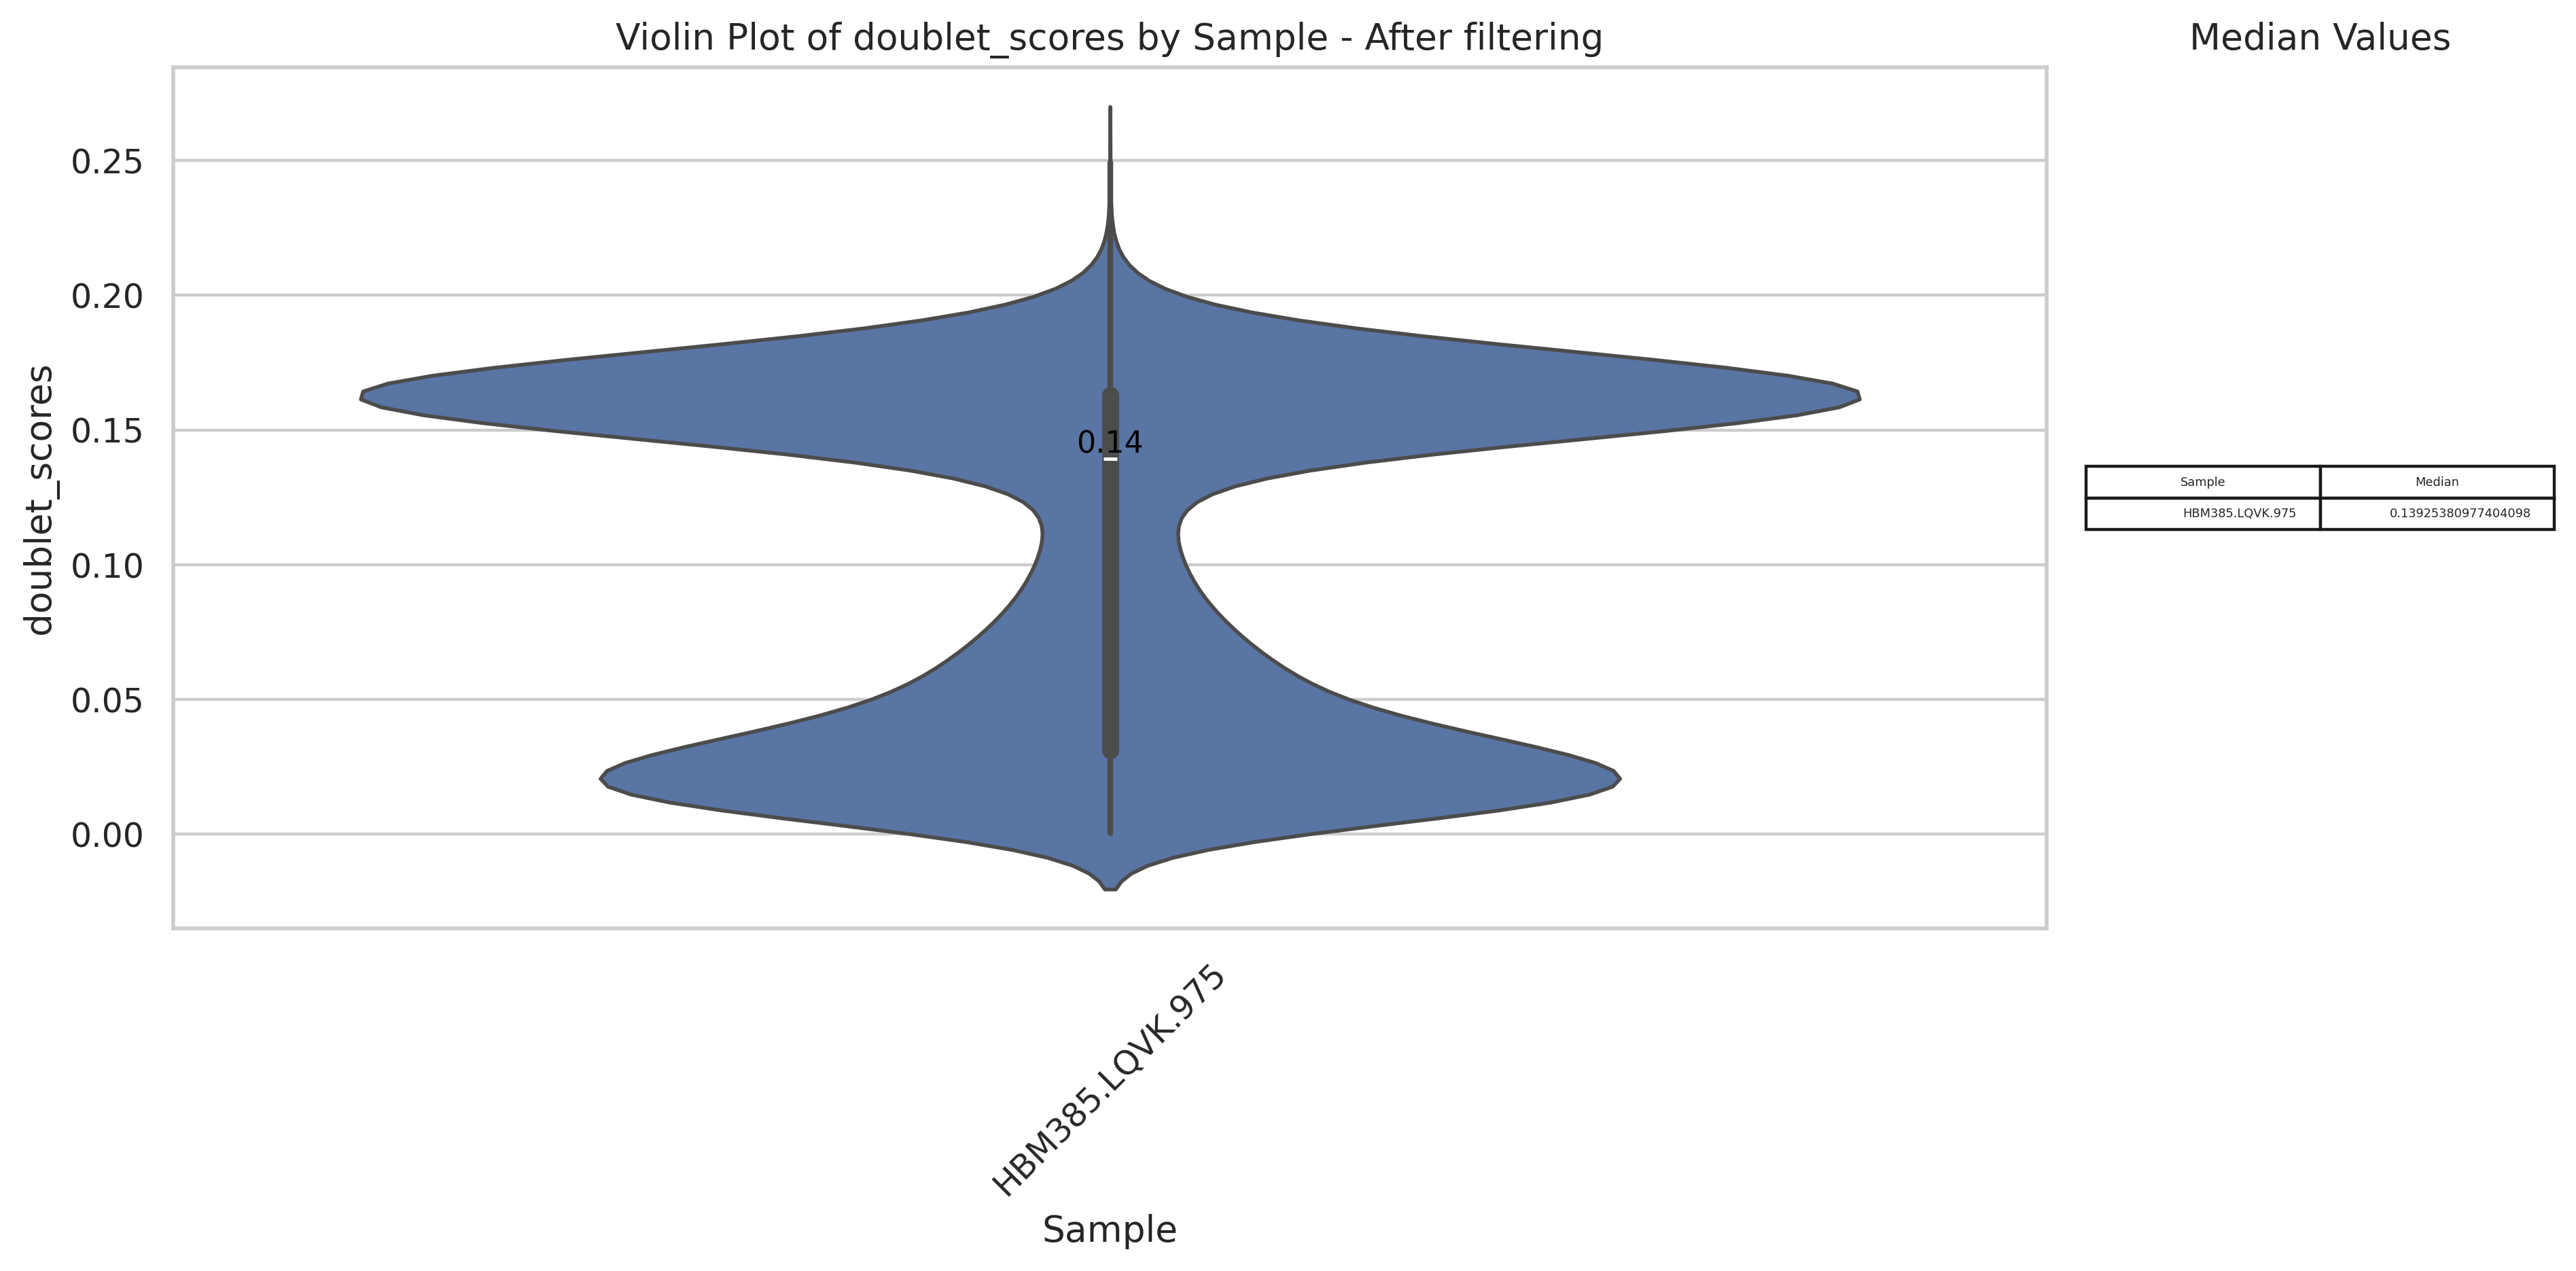

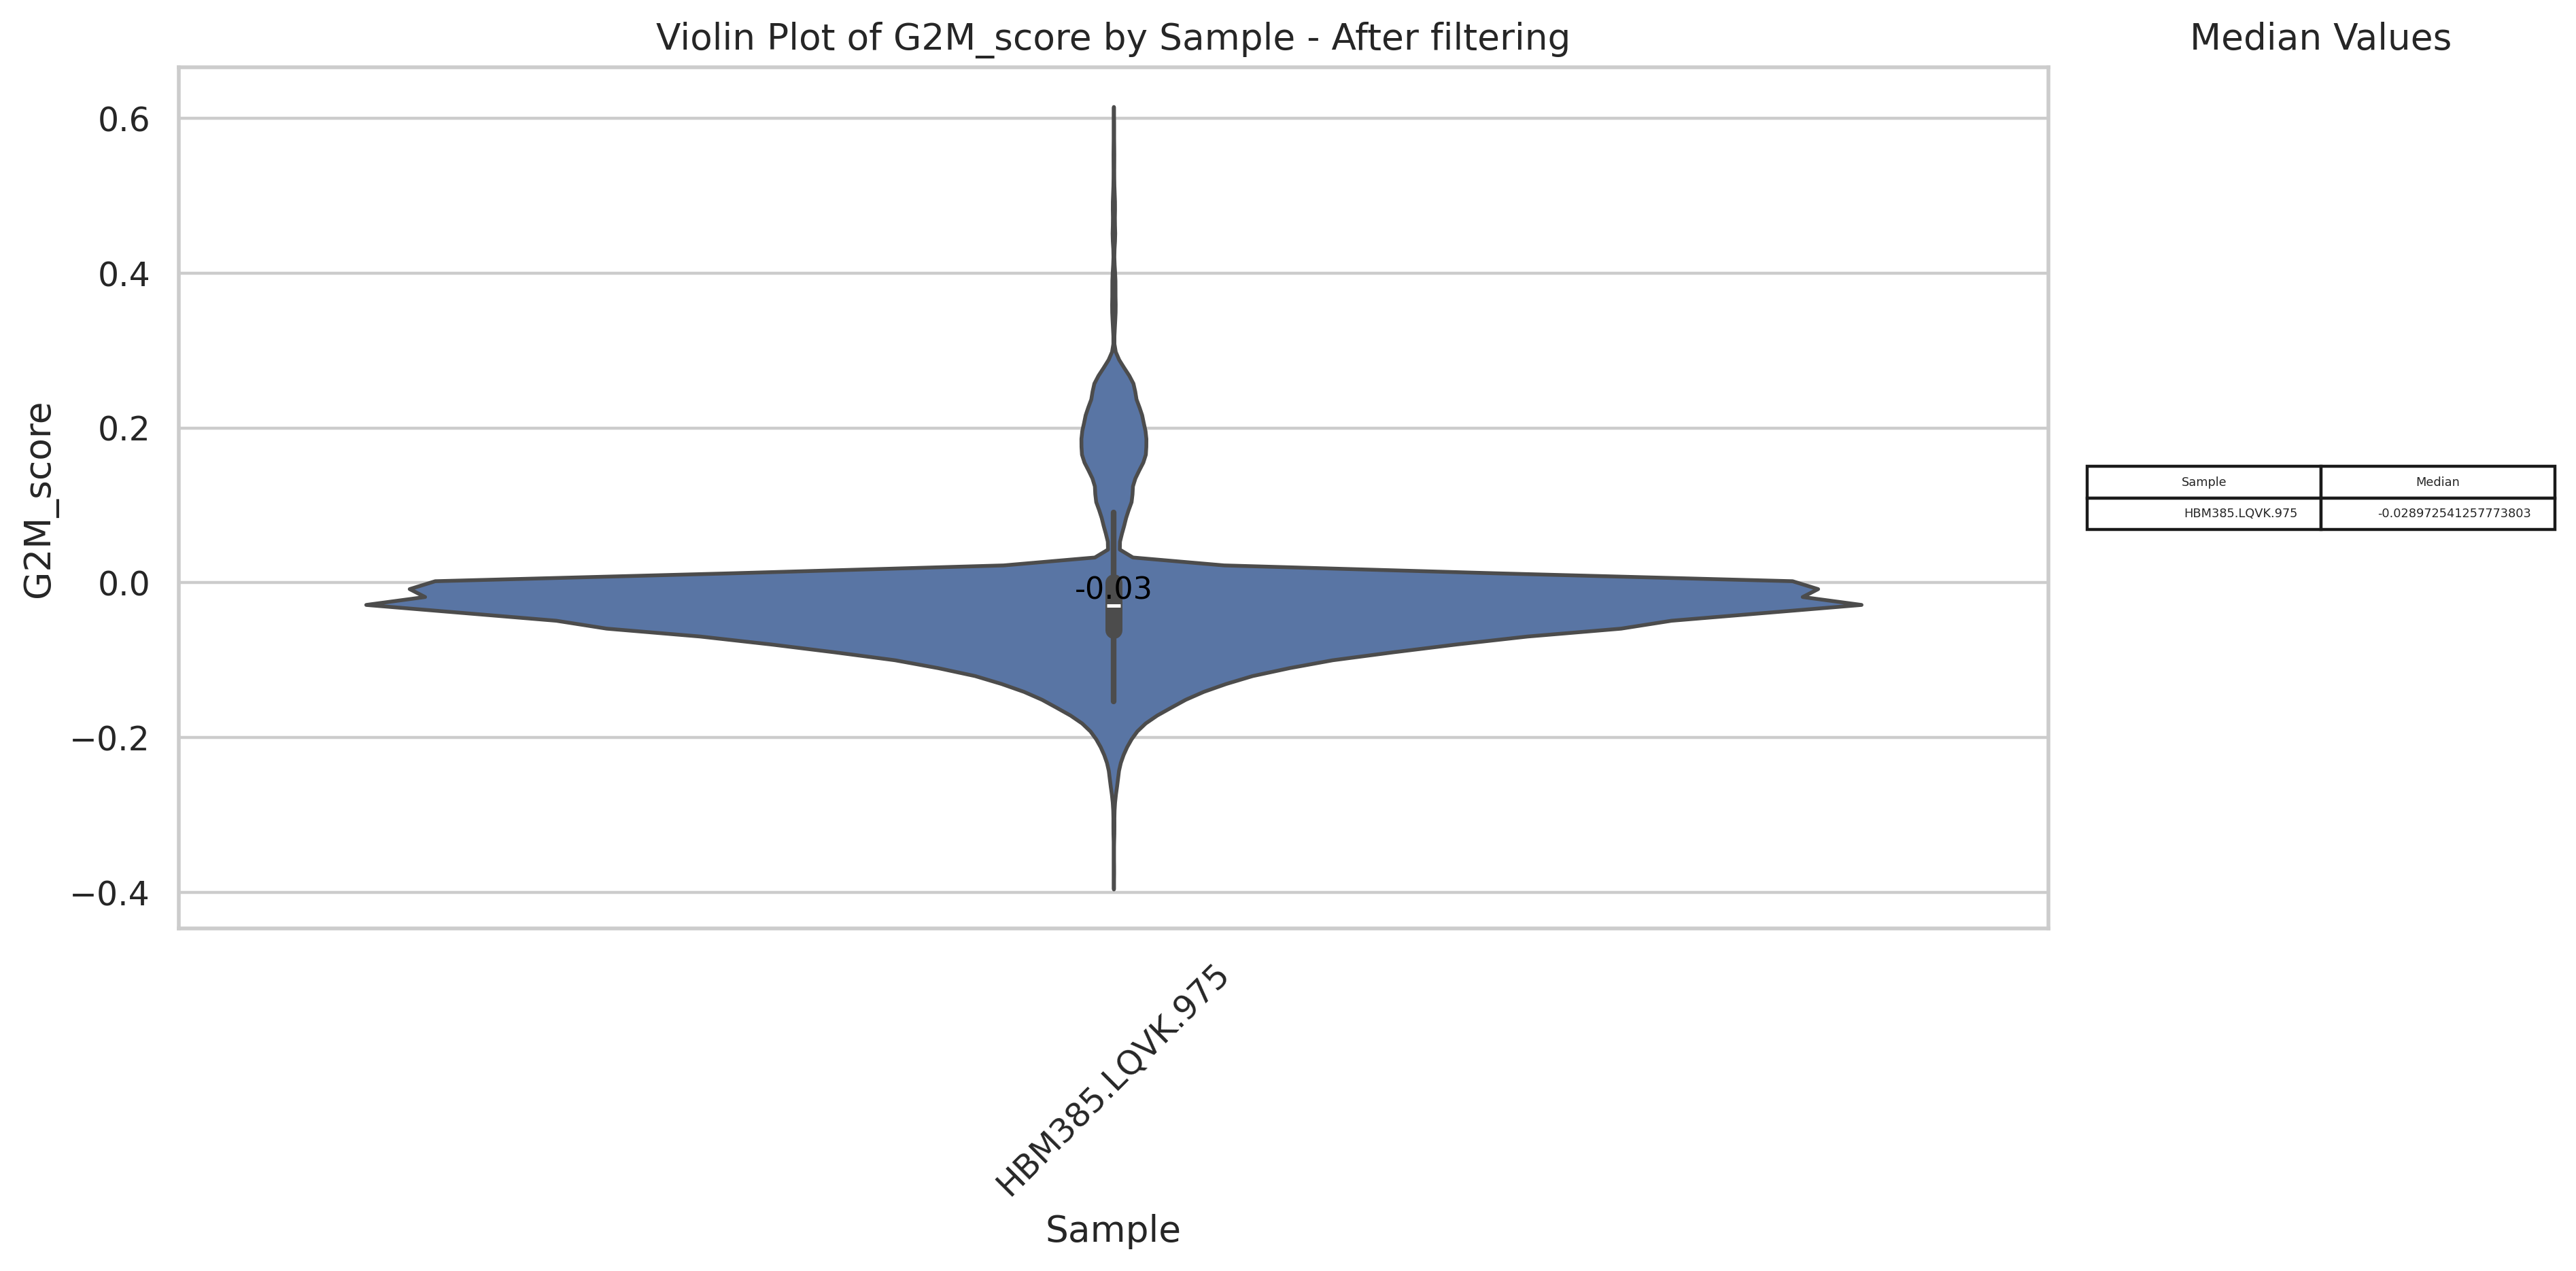

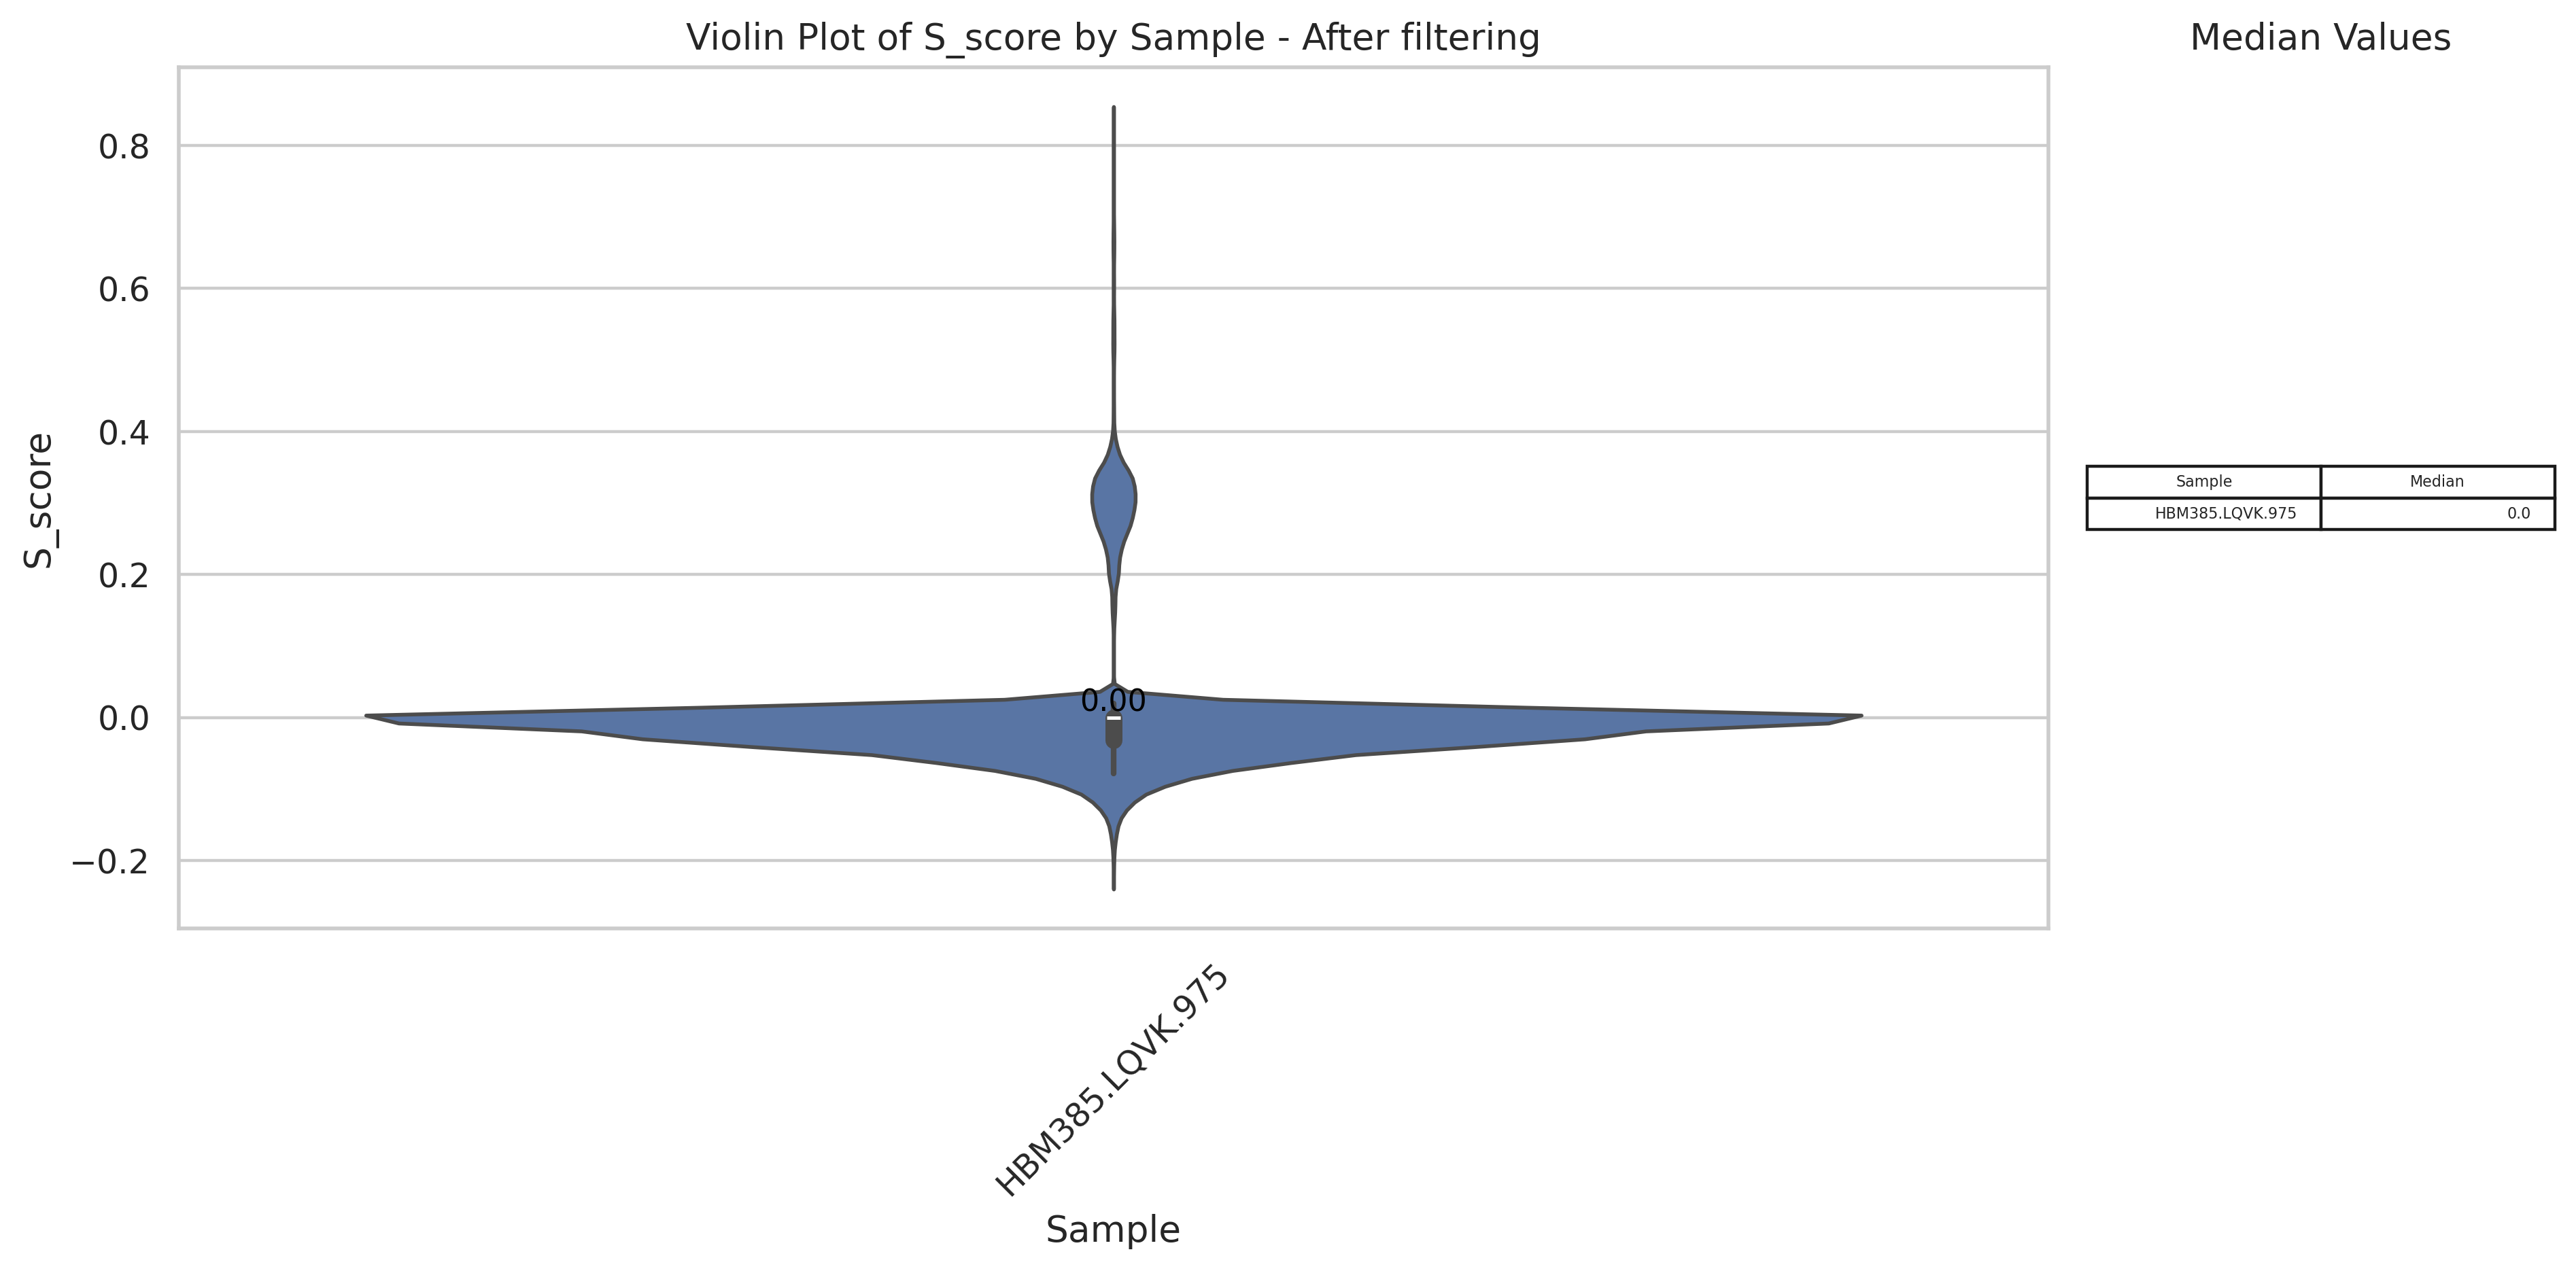

In [48]:
variables = 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'doublet_scores', 'G2M_score', 'S_score' 

for var in variables:

    fig, ax = plt.subplots(figsize=(12, 6), ncols=2, gridspec_kw={'width_ratios': [4, 1]})

    sb.violinplot(data=filtered_object.obs, x='dataset', y=var, ax=ax[0])
   
    medians = filtered_object.obs.groupby('dataset')[var].median()

    for sample, median in medians.items():
        ax[0].text(sample, median, f'{median:.2f}', ha='center', va='bottom', color='black', fontsize=10)
    
    ax[0].set_title(f'Violin Plot of {var} by Sample - After filtering')
    ax[0].set_xlabel('Sample')
    ax[0].set_ylabel(var)
    ax[0].tick_params(axis='x', rotation=45)

    median_df = pd.DataFrame({'Sample': medians.index, 'Median': medians.values})

    ax[1].axis('off')
    ax[1].table(cellText=median_df.values, colLabels=median_df.columns, loc='center')
    ax[1].set_title('Median Values')
    
    plt.tight_layout()
    plt.show()

## Data Export

In [49]:
filtered_object.raw = filtered_object.copy()

filtered_object.layers['raw_counts'] = filtered_object.X.copy()

filtered_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(filtered_object, inplace = False)["X"]
)

filtered_object

normalizing counts per cell
    finished (0:00:00)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 10720 × 60286
    obs: 'cell_id', 'dataset', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'hugo_symbol', 'ensembl', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'corrected_ensembl'
    layers: 'spliced', 'spliced_unspliced_sum', 'unspliced', 'raw_counts', 'sqrt_norm'

In [50]:
filtered_object.var.dtypes

hugo_symbol              category
ensembl                    object
mt                           bool
ribo                         bool
n_cells_by_counts           int64
mean_counts               float32
log1p_mean_counts         float32
pct_dropout_by_counts     float64
total_counts              float32
log1p_total_counts        float32
corrected_ensembl          object
dtype: object

In [51]:
filtered_object.var['mt'].value_counts()

mt
False    60263
True        23
Name: count, dtype: int64

In [52]:
filtered_object.var['mt'] = filtered_object.var['mt'].astype(str)

In [53]:
print(filtered_object.var.dtypes)

hugo_symbol              category
ensembl                    object
mt                         object
ribo                         bool
n_cells_by_counts           int64
mean_counts               float32
log1p_mean_counts         float32
pct_dropout_by_counts     float64
total_counts              float32
log1p_total_counts        float32
corrected_ensembl          object
dtype: object


In [54]:
filtered_object.write_h5ad(f'../hubmap/data/HBM385_sc_rna_hubmap_filtered_sk_{timestamp}.h5ad')